In [1]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
from collections import deque
import pickle
path_base = 'stable/'
import os
from stable_baselines.common.vec_env import DummyVecEnv,VecCheckNan
from stable_baselines.ddpg.policies import MlpPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines.ddpg.policies import FeedForwardPolicy
from stable_baselines import DDPG

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-

In [2]:
def softmax(y, theta = 1.0):
    y = y * float(theta)
    y = y - np.max(y)
    y = np.exp(y)
    ax_sum = np.sum(y)
    p = y / ax_sum
    return p

In [3]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.num_stocks = params['num_stocks']
        self.balance_normal = params['balance_normal']
        self.price_normal = params['price_normal']
        self.num_prev = params['num_prev']
        self.shares_normal = params['shares_normal']
        self.dfs = df
        self.state_dimensions = self.num_prev*self.num_stocks*4+self.num_stocks+1
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = np.zeros(self.num_stocks*2), high = np.ones(self.num_stocks*2), dtype = np.float32)
        self.observation_space = spaces.Box(low = -np.ones(self.state_dimensions), high = np.ones(self.state_dimensions), dtype = np.float32)

    def reset(self, intial_balance = 10000, shares_held = None):

        if self.train:
            self.current_step = np.random.randint(self.num_prev, self.max_steps)
        else:
            self.current_step = self.num_prev
        self.balance = intial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = np.zeros((1, self.num_stocks))
        self.current_price = self.get_price()
        self.highest_price = 0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.set_high()
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance,
        }
        ons,_ =  self.observe()
        return ons
        
    def get_price(self):
        return np.array([np.random.uniform(df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]) for df in self.dfs]).reshape((1, self.num_stocks))
      
    def set_high(self):
        high = np.array([df.loc[self.current_step, 'High'] for df in self.dfs]).reshape((1, self.num_stocks))
        self.highest_price = np.maximum(self.highest_price, high)

    def get_state(self,i):
        return [self.dfs[i].loc[self.current_step-self.num_prev+2:self.current_step+1,'Open'],self.dfs[i].loc[self.current_step-self.num_prev+2:self.current_step+1,'High'],self.dfs[i].loc[self.current_step-self.num_prev+2:self.current_step+1,'Low'],self.dfs[i].loc[self.current_step-self.num_prev+2:self.current_step+1,'Close']]
    
    def observe(self):
#         print(self.current_step)
        frame = self.frame.copy()
        for i in range(self.num_stocks):
            frame[0, 4*self.num_prev*i:self.num_prev*4*i+self.num_prev*4] = np.array(self.get_state(i)).reshape((1,4*self.num_prev)) - self.frame[0, 4*self.num_prev*i:self.num_prev*4*i+self.num_prev*4]
            self.frame[0, 4*self.num_prev*i:self.num_prev*4*i+self.num_prev*4] = self.frame[0, 4*self.num_prev*i:self.num_prev*4*i+self.num_prev*4] + frame[0, 4*self.num_prev*i:self.num_prev*4*i+self.num_prev*4]
            frame[0, 4*self.num_prev*i:self.num_prev*4*i+self.num_prev*4] /= self.price_normal
            
        frame[0, self.num_prev*self.num_stocks*4:-1] = self.frame[0, self.num_prev*self.num_stocks*4:-1] = self.shares_held/self.shares_normal
        frame[0, -1] =  self.frame[0, -1] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance
        }
        return frame.reshape(self.state_dimensions), self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance += np.sum(action[:, :self.num_stocks]*self.current_price)
        self.balance -= np.sum(action[:, self.num_stocks:]*self.current_price)

    def update_shares(self, action):
        self.shares_held -= action[:, :self.num_stocks]
        self.shares_held +=  action[:, self.num_stocks:]

    def take_action(self, action):
        self.current_price = self.get_price()
        action[:, :self.num_stocks] = np.floor(action[:, :self.num_stocks] *self.shares_held)
        action[:, self.num_stocks:] = np.floor(action[:, self.num_stocks:] * self.balance / self.current_price)
        self.set_high()
        self.update_balance(action)
        self.update_shares(action)
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update_worth(reward)
        return reward
            
    def step(self, actions):
        buy_sum = np.sum(actions[self.num_stocks:])
        actions[self.num_stocks:] = softmax(actions[self.num_stocks:])
        actions[self.num_stocks:] *= np.min([buy_sum,1])
#         print(actions)
        action = actions.reshape((1,self.num_stocks*2)).copy()
        self.current_step += 1
        if self.current_step >= self.max_steps-1 or self.done:
            self.done = True
            return np.zeros((self.state_dimensions)), 0, self.done, self.info
        if np.sum(action[:, self.num_stocks:]) > 1:
            print('gadbad')
        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    params = {
        'num_stocks' : len(locations),
        'balance_normal' : 1000000,
        'shares_normal' : 1000,
        'price_normal': 100,
        'num_prev' : 10,
    }
    return StockEnv(dfs, params, train)

In [6]:
def plot_profit(files,profitst,max_steps,i):
    df1 = pd.read_csv(files[0])
    df2 = pd.read_csv(files[1])
    plt.figure(figsize = [8, 4])
    plt.plot(profitst[:])
    plt.plot(df1.loc[:max_steps,'High']*10000/df1.loc[0,'Low'])
    plt.plot(df2.loc[:max_steps,'High']*10000/df2.loc[0,'Low'])
    plt.legend(['agent','follow '+files[0],'follow '+files[1]])
    plt.grid()
    plt.title('profit for iter ' + str(i))
    plt.show()
    plt.figure(figsize = [8, 4])
    plt.plot(profitst[:])
    plt.grid()
    plt.title('profit for iter ' + str(i))
    plt.show()
    
def plot_action(actionst,i):
    plt.figure(figsize = [6, 4])
    plt.plot(actionst[:,0])
    plt.plot(-actionst[:,2])
    plt.legend(['agent 0','agent 2'])
    plt.grid()
    plt.title('action stock 1 for iter ' +str(i) )
    plt.show()
    plt.figure(figsize = [6,4])
    plt.plot(actionst[:,1])
    plt.plot(-actionst[:,3])
    plt.grid()
    plt.legend(['agent 1','agent 3'])
    plt.title('action stock 2 for iter ' +str(i))
    plt.show()

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.70722127 0.9974234  0.28017285 0.7198272 ]]
['AAPL.csv' 'BPCL.csv']


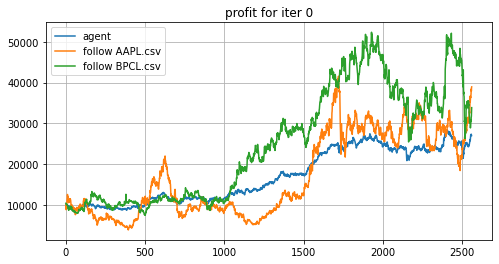

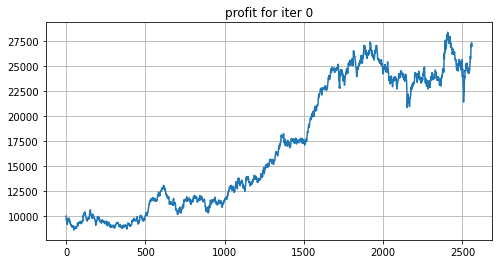

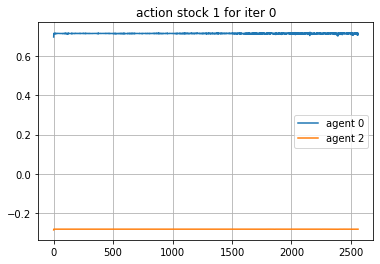

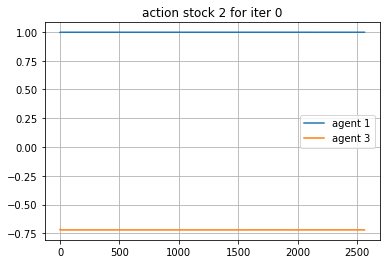

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.9404347  0.9994268  0.27018166 0.70946383]]
['AMZN.csv' 'AMZN.csv']


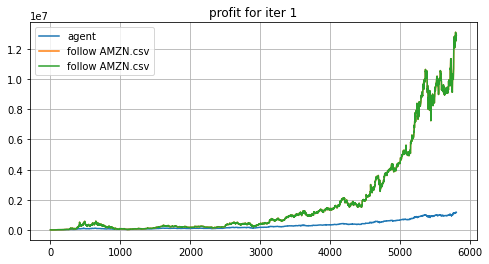

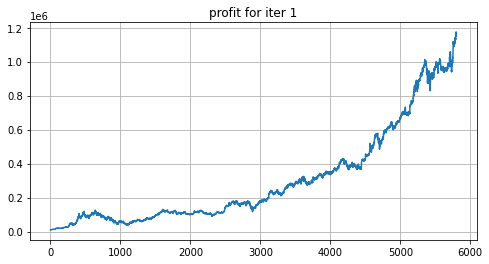

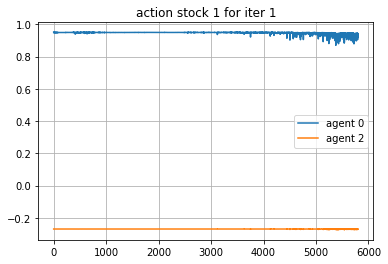

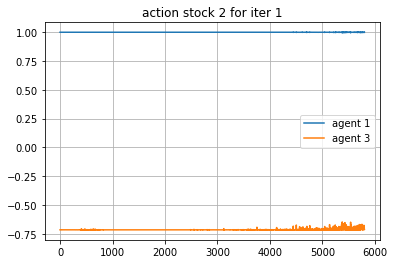

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.20697615 0.99947214 0.24466676 0.49810618]]
['DXC.csv' 'DXC.csv']


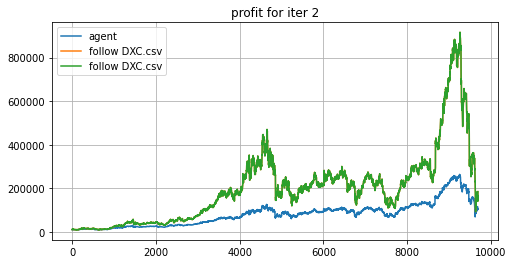

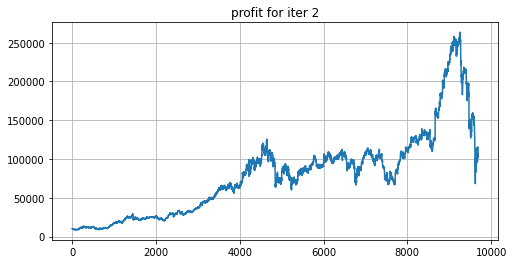

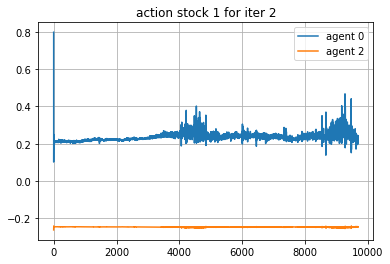

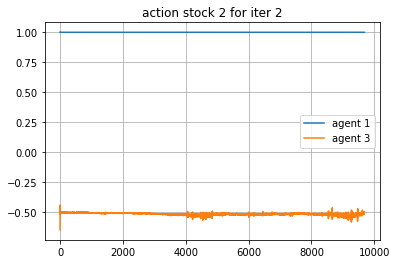

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.94065815 0.9999678  0.08237132 0.09862507]]
['INFY.csv' 'GOOG.csv']


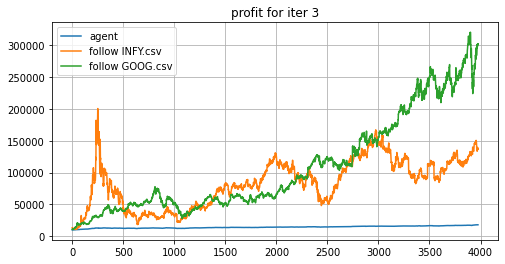

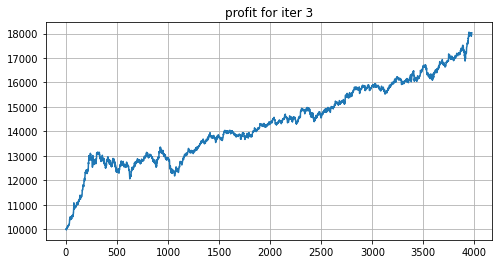

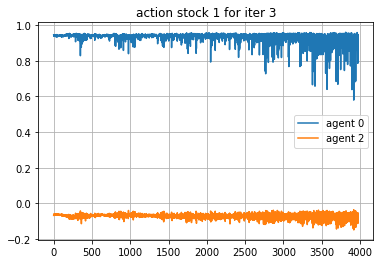

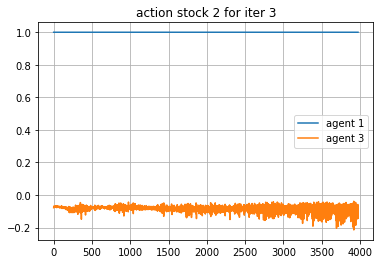

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.99764496 0.9999992  0.2683065  0.7229055 ]]
['RELIN.csv' 'MSFT.csv']


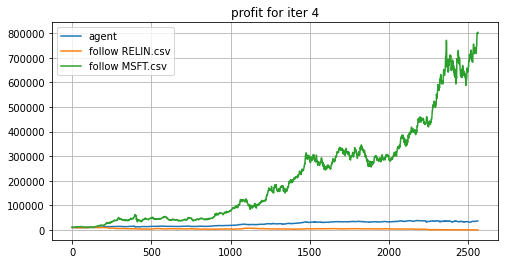

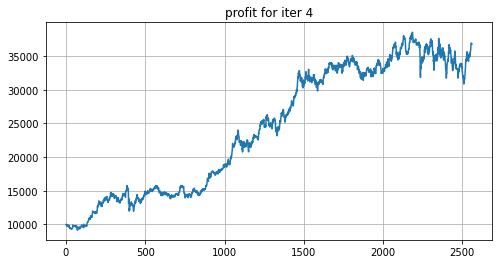

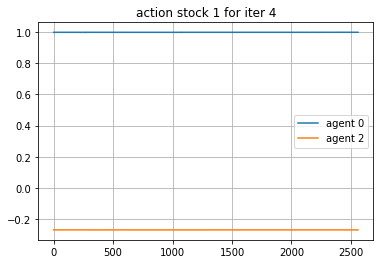

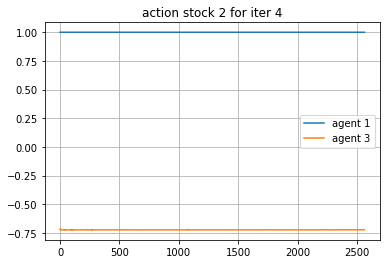

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.5450078  0.76887816 0.26850122 0.7188944 ]]
['GOOG.csv' 'INFY.csv']


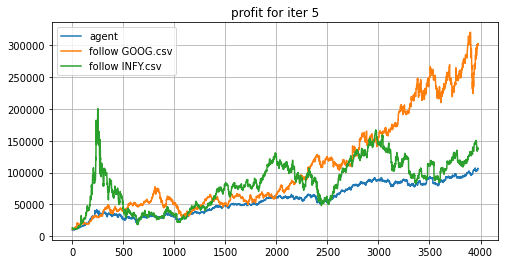

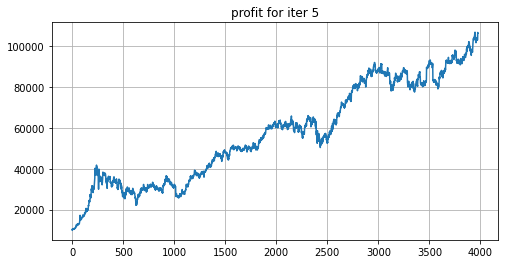

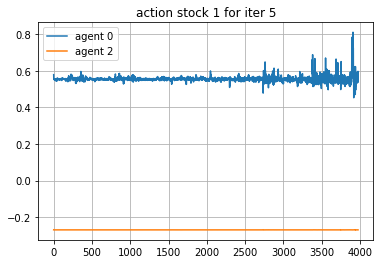

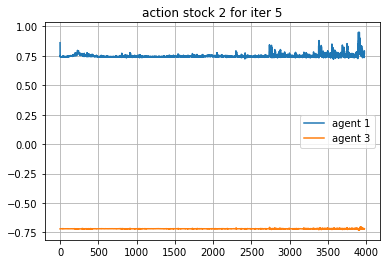

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.80451745 0.05274513 0.26915818 0.7278024 ]]
['MSFT.csv' 'AMZN.csv']


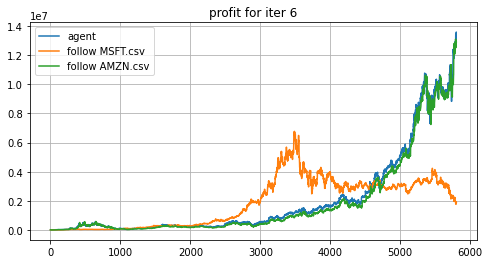

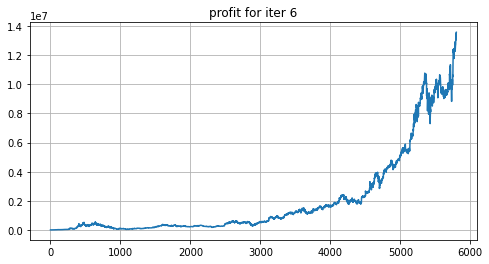

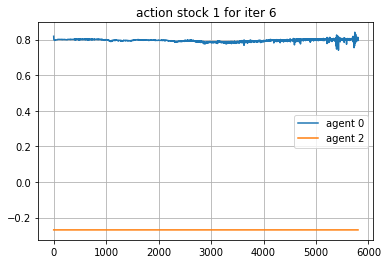

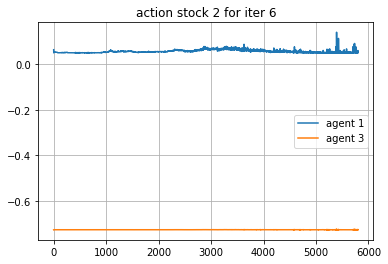

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.99956596 0.99314964 0.2689396  0.7310347 ]]
['PNB.csv' 'AMZN.csv']


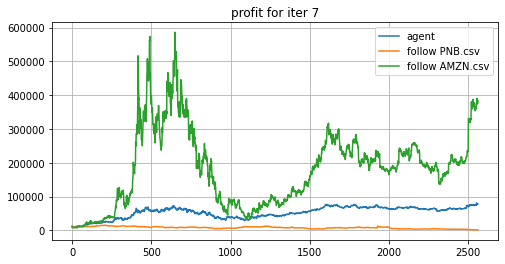

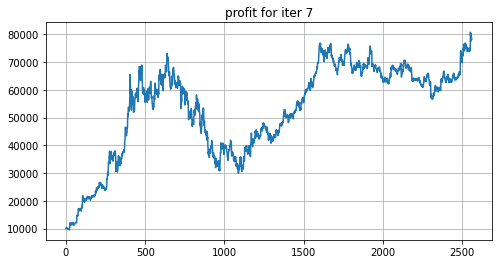

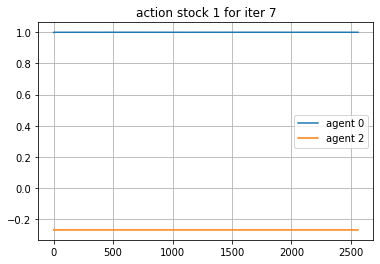

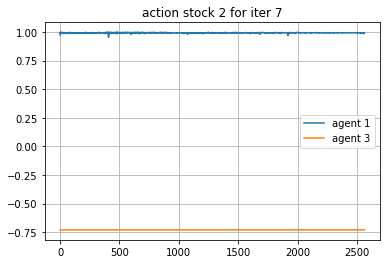

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.05406708 0.04320648 0.26893884 0.73100764]]
['AMZN.csv' 'PNB.csv']


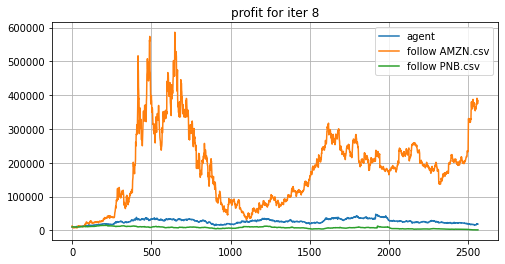

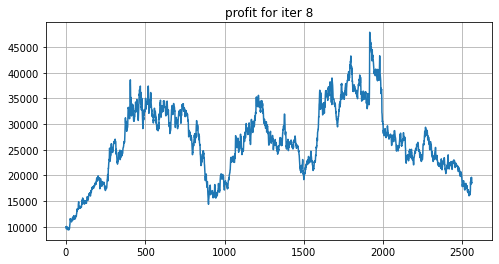

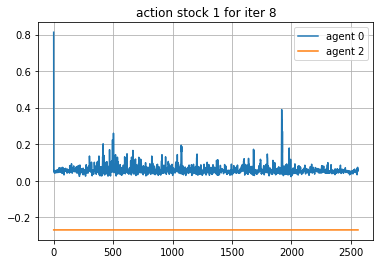

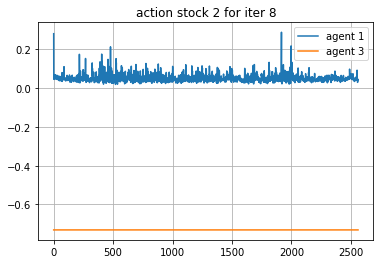

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.9671447 0.9995925 0.2689414 0.7310583]]
['GOOG.csv' 'M.csv']


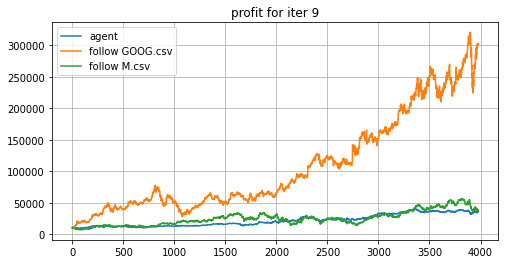

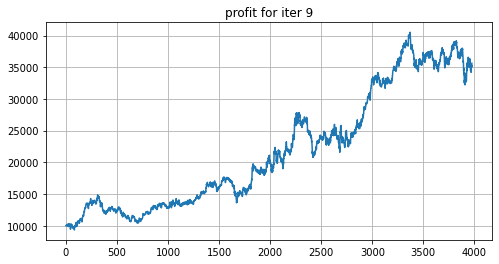

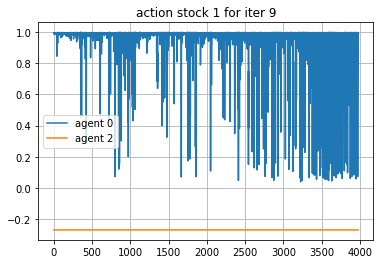

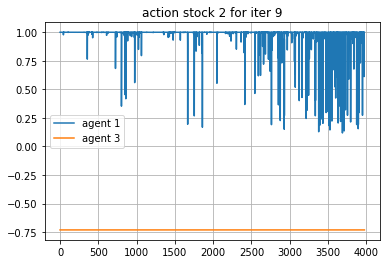

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.95852154 0.9997487  0.26894143 0.73105836]]
['PNB.csv' 'BPCL.csv']


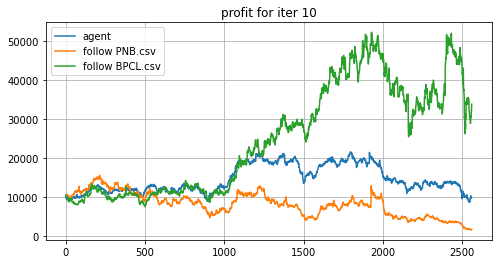

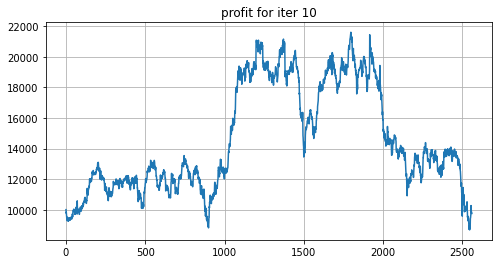

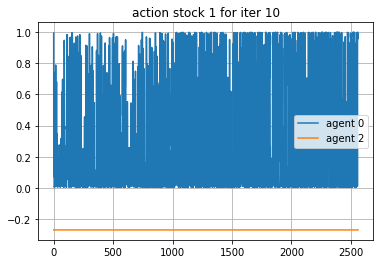

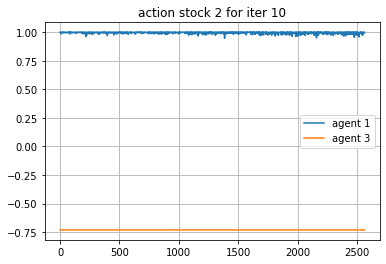

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.00301701 0.19062823 0.26894373 0.7310563 ]]
['GOOG.csv' 'MSFT.csv']


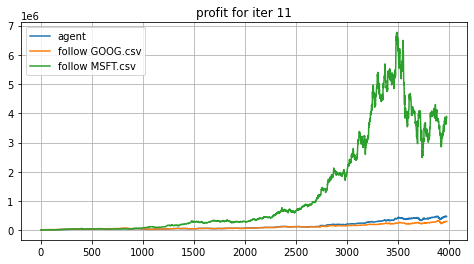

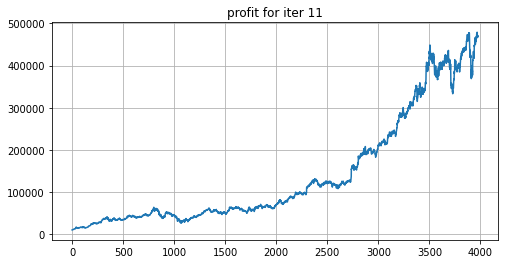

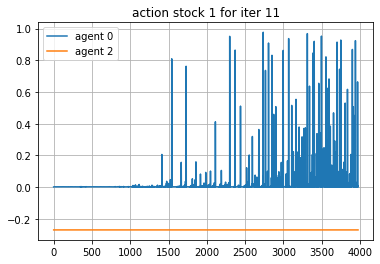

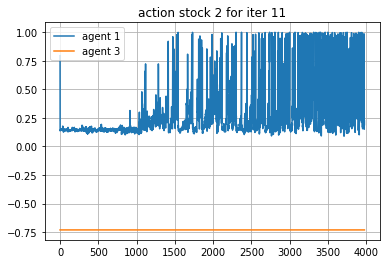

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.00655615 0.9986439  0.26896757 0.73103243]]
['MSFT.csv' 'PNB.csv']


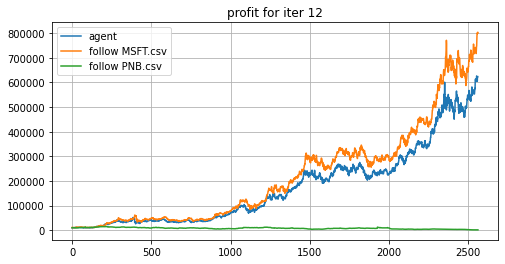

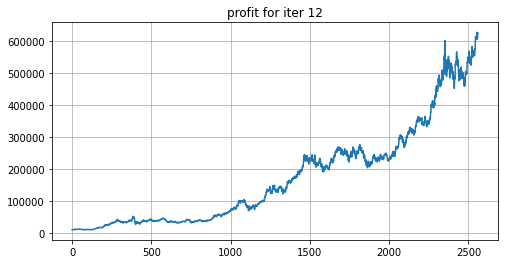

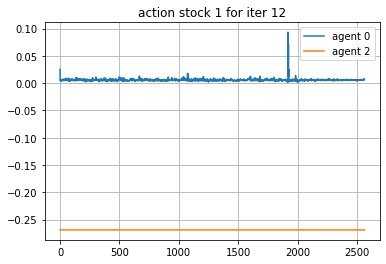

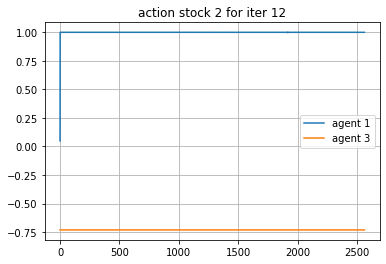

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.02546892 0.17659292 0.43439615 0.56560385]]
['INFY.csv' 'GOOG.csv']


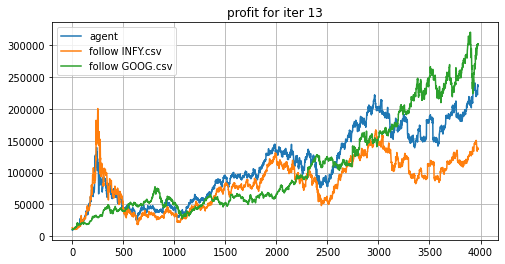

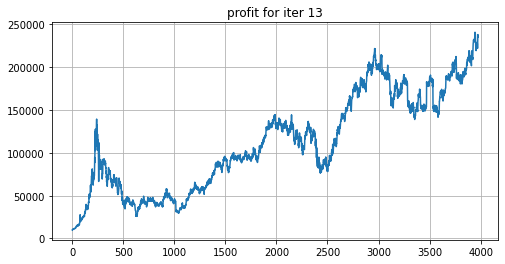

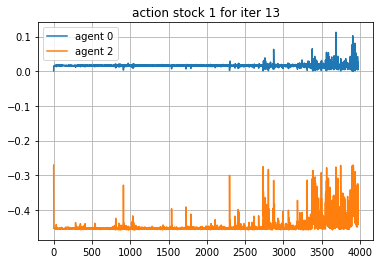

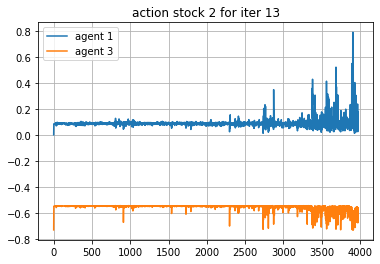

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.0520220e-04 2.9984117e-04 2.7164170e-01 7.2835827e-01]]
['AAPL.csv' 'RELIN.csv']


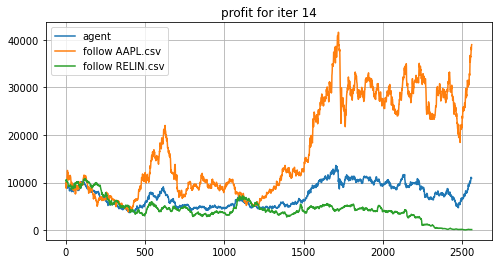

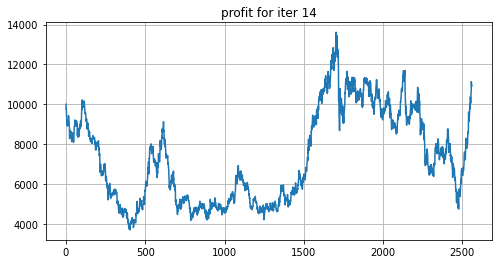

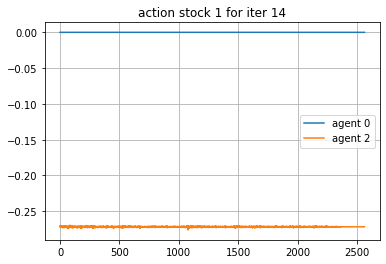

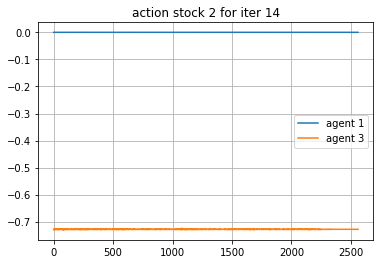

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[5.4845214e-04 9.8206210e-01 4.9716786e-01 5.0283217e-01]]
['PNB.csv' 'INFY.csv']


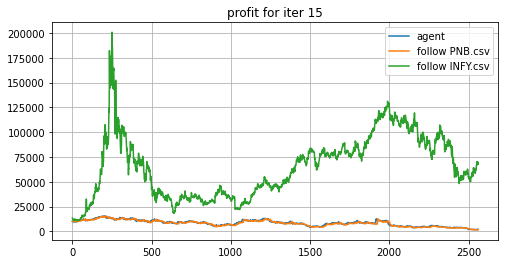

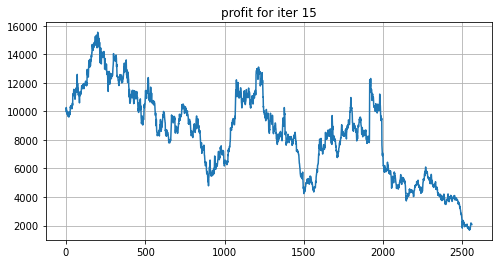

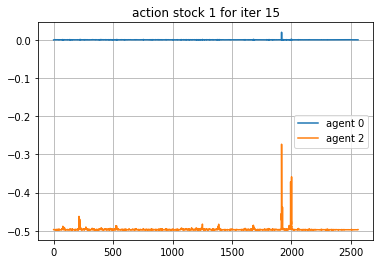

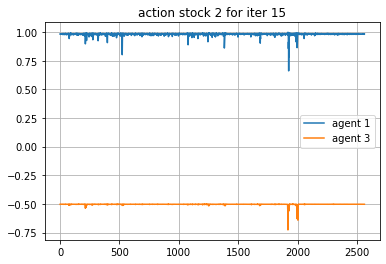

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[7.3224306e-05 9.5359910e-01 4.9833101e-01 5.0166899e-01]]
['BPCL.csv' 'AAPL.csv']


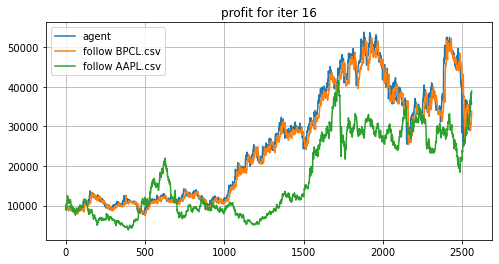

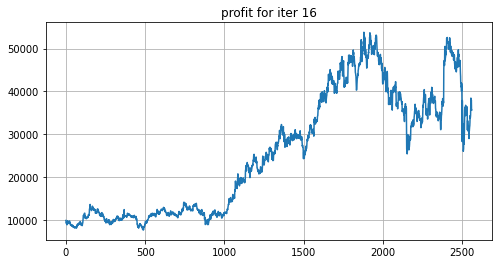

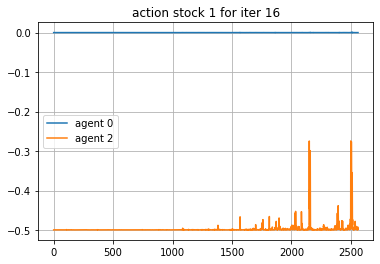

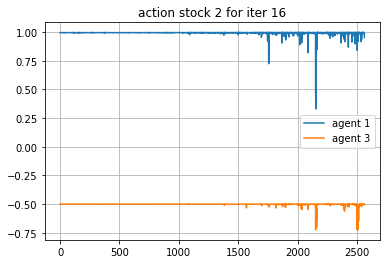

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.0371208e-05 9.9163473e-01 4.8198825e-01 5.1801175e-01]]
['INFY.csv' 'PNB.csv']


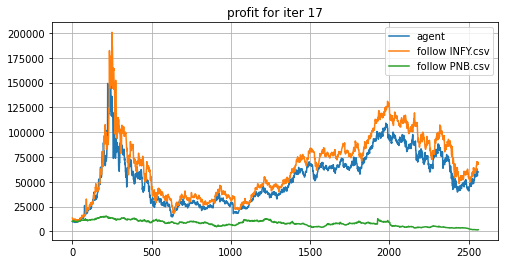

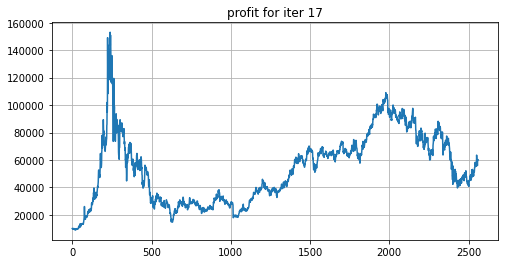

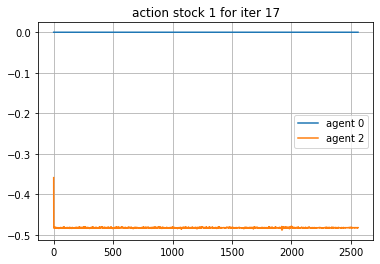

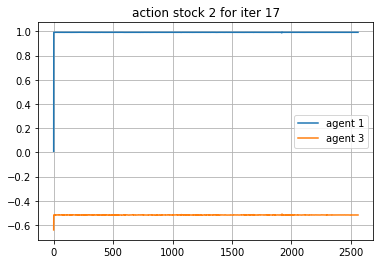

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0028224  0.9981687  0.5288894  0.47111058]]
['DXC.csv' 'MSFT.csv']


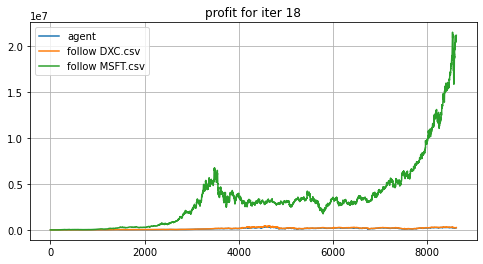

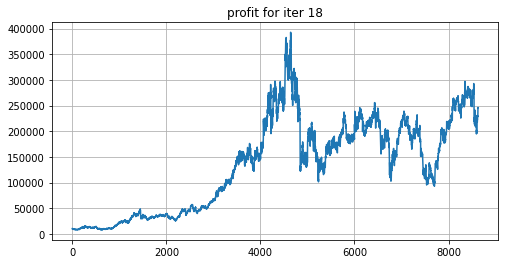

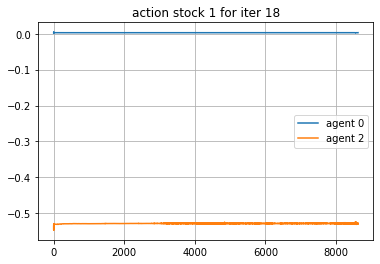

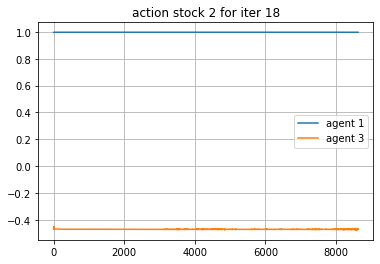

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[5.9527159e-04 9.9948525e-01 3.5083887e-01 6.4916110e-01]]
['GOOG.csv' 'MSFT.csv']


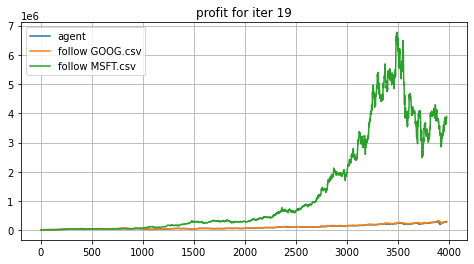

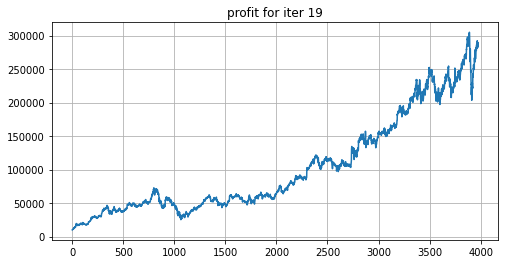

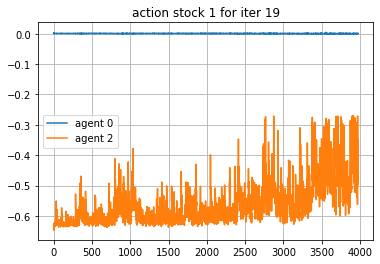

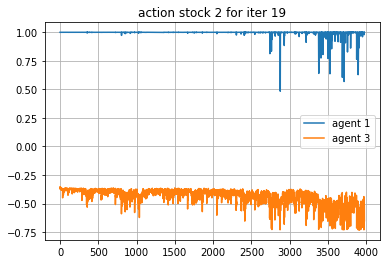

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[3.1501055e-04 9.9985474e-01 6.9164133e-01 3.0835867e-01]]
['MSFT.csv' 'AAPL.csv']


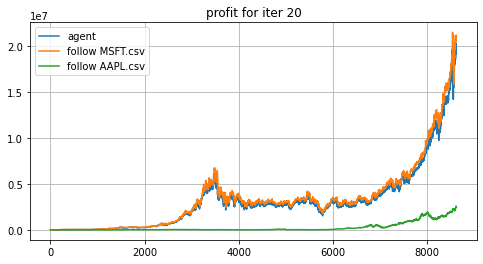

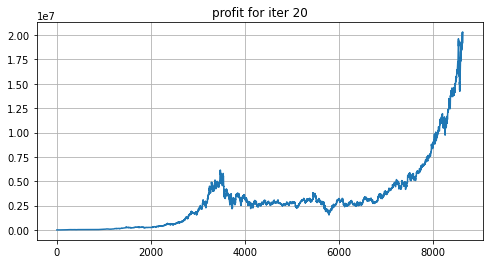

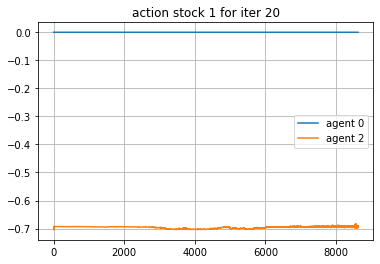

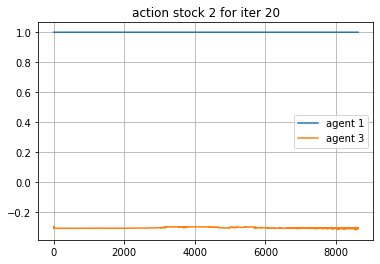

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.0430813e-06 9.9912447e-01 2.6939085e-01 7.3060912e-01]]
['DXC.csv' 'PNB.csv']


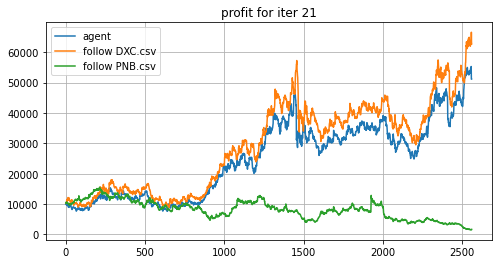

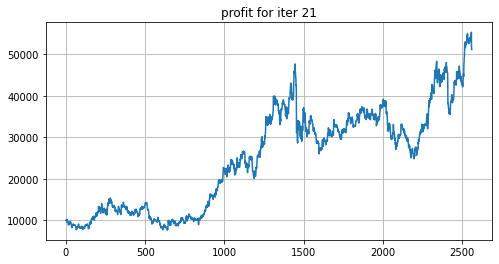

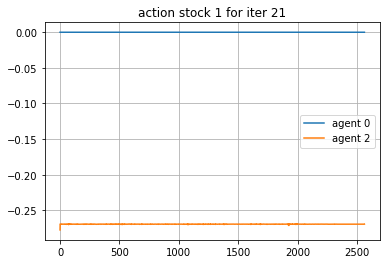

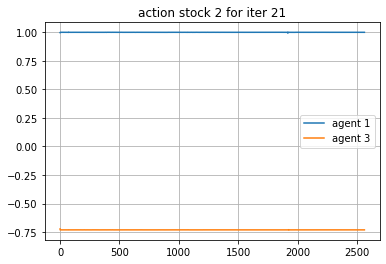

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[4.1723251e-07 9.9999285e-01 5.0118208e-01 4.9881789e-01]]
['PCG.csv' 'IBM.csv']


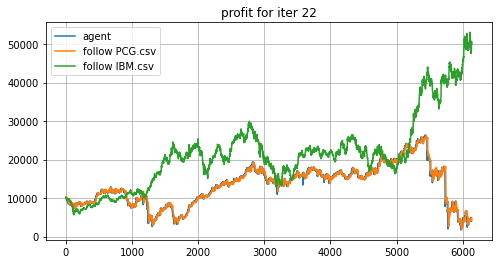

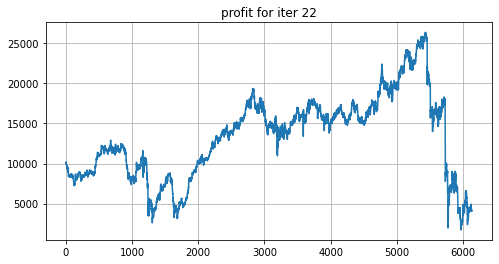

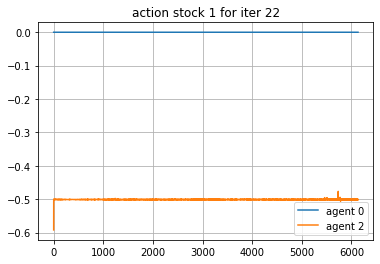

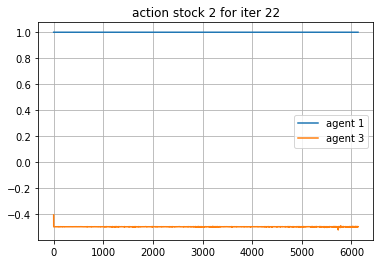

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99989897 0.50019366 0.49980634]]
['BPCL.csv' 'DXC.csv']


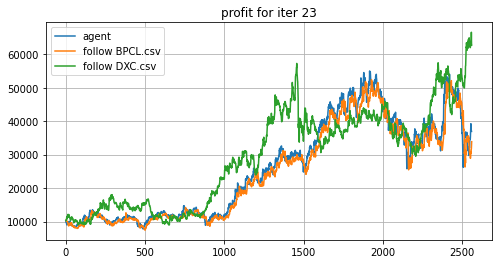

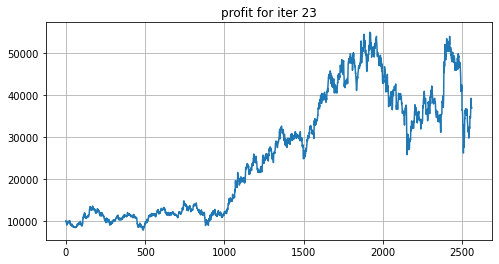

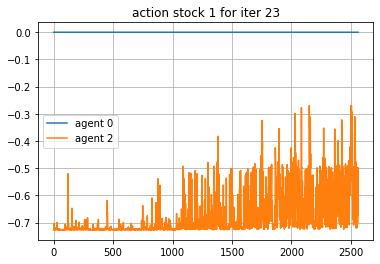

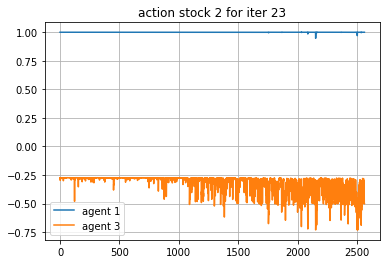

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[8.9406967e-08 9.9999988e-01 6.6071123e-01 3.3928874e-01]]
['AMZN.csv' 'PCG.csv']


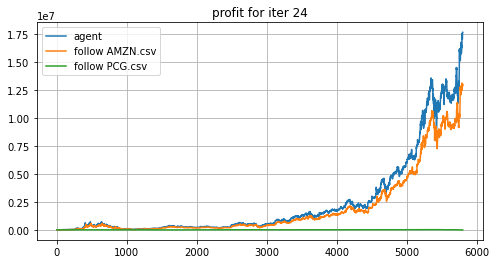

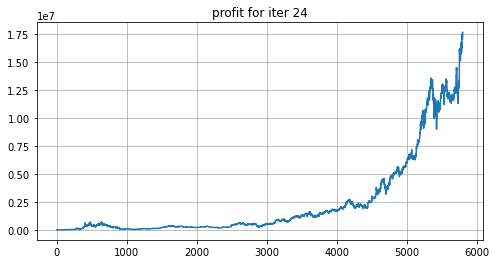

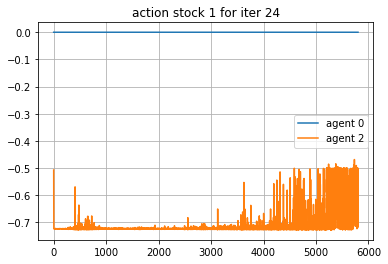

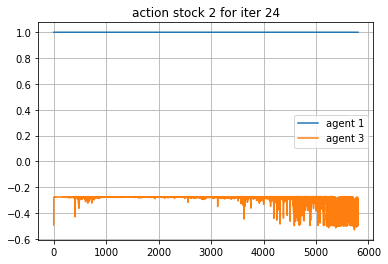

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[2.9802322e-08 9.9999988e-01 7.2985691e-01 2.7014309e-01]]
['M.csv' 'IBM.csv']


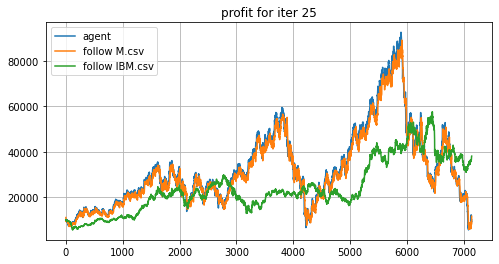

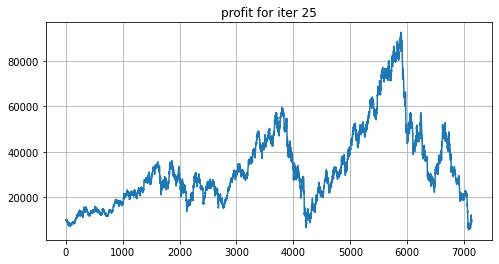

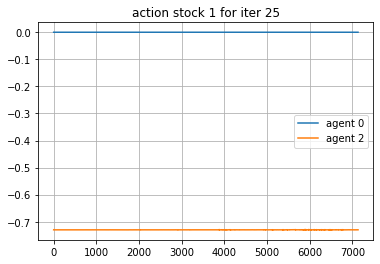

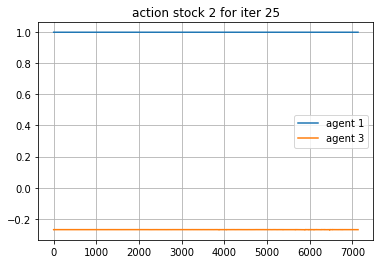

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.9999989  0.73093903 0.26906097]]
['M.csv' 'MSFT.csv']


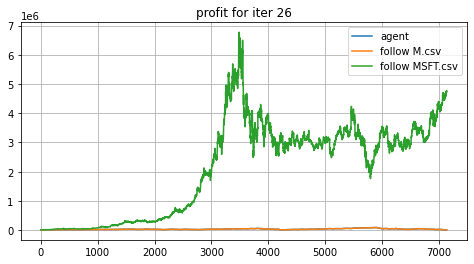

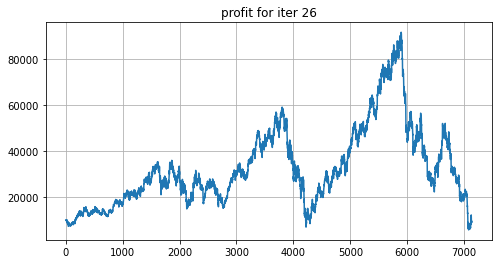

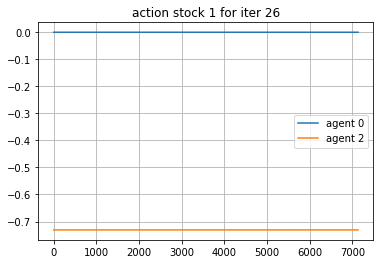

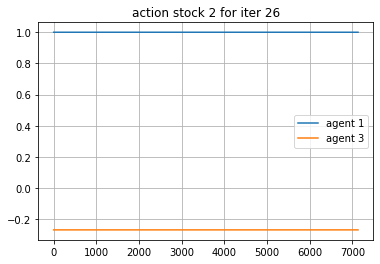

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.9999891  0.73104036 0.2689596 ]]
['AAPL.csv' 'PCG.csv']


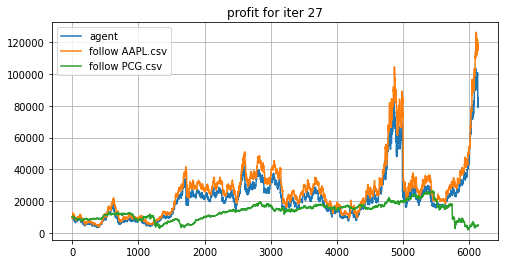

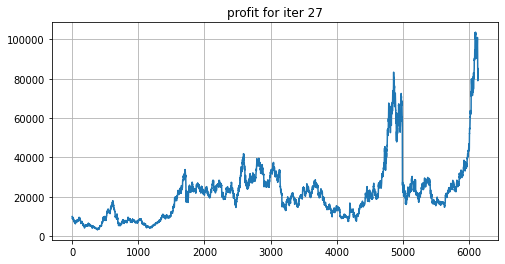

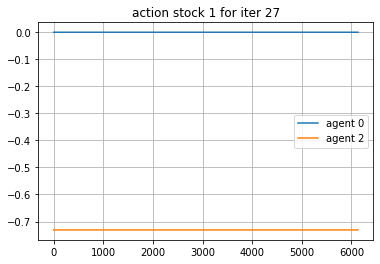

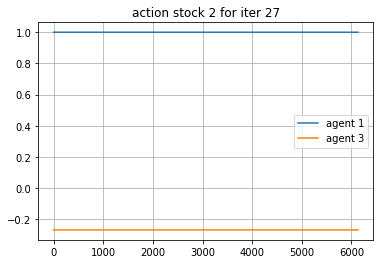

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.9999976  0.49999732 0.5000027 ]]
['PNB.csv' 'INFY.csv']


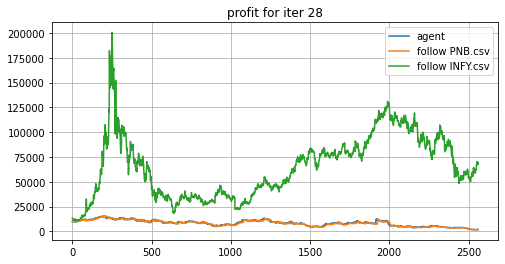

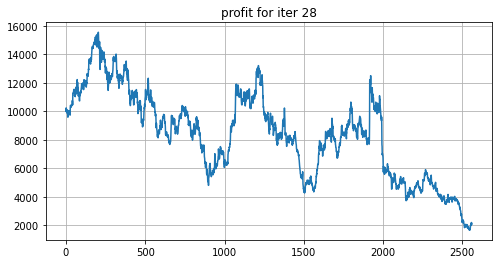

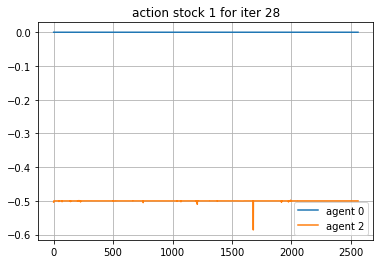

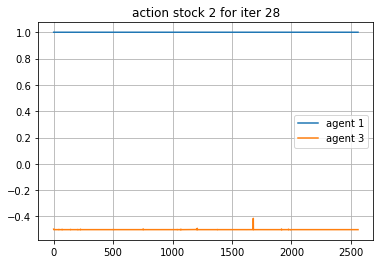

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99999964 0.7308779  0.26912212]]
['MSFT.csv' 'BPCL.csv']


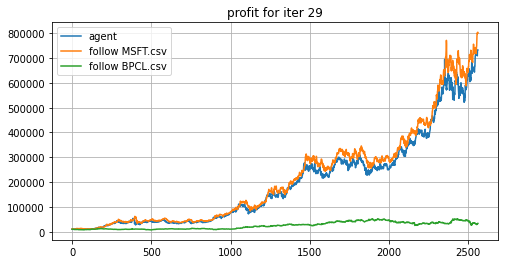

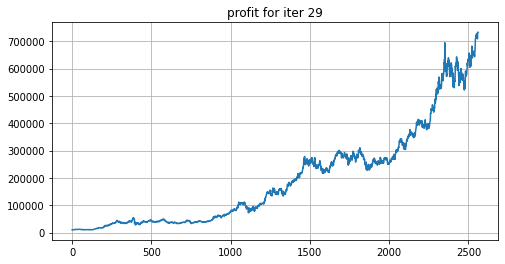

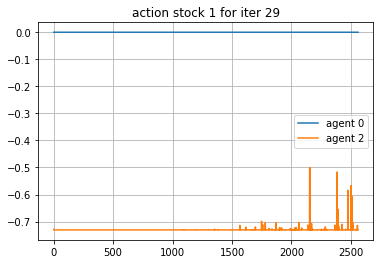

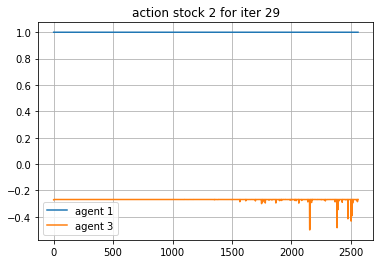

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99997425 0.7310514  0.26894858]]
['AAPL.csv' 'BPCL.csv']


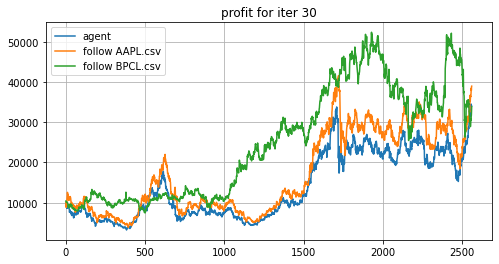

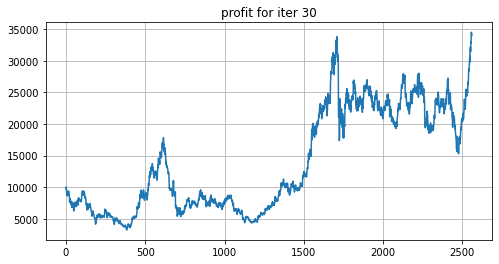

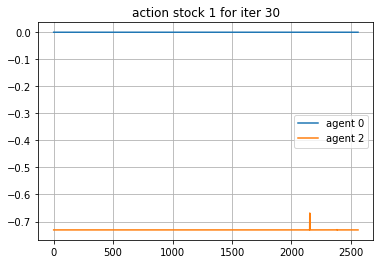

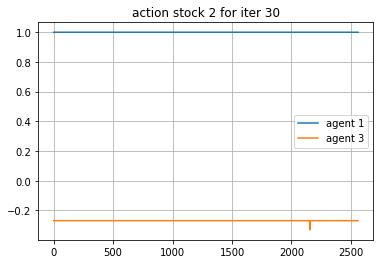

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[7.3909760e-06 4.6229285e-01 7.3081940e-01 2.6918060e-01]]
['INFY.csv' 'BPCL.csv']


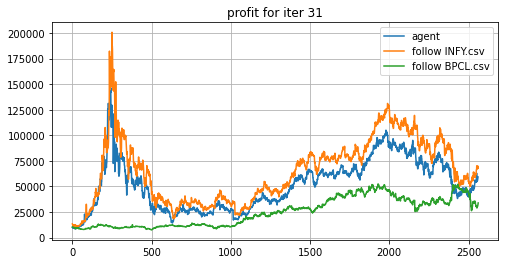

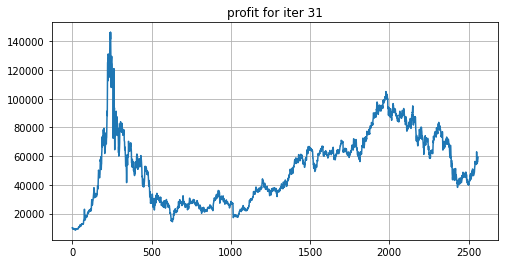

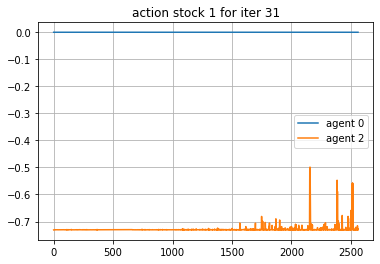

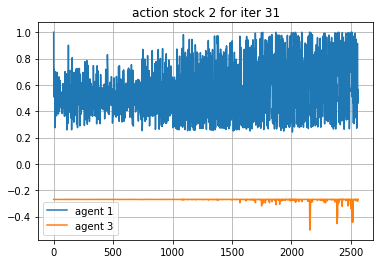

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.1324883e-06 1.4916965e-01 6.8635136e-01 3.1364864e-01]]
['BPCL.csv' 'DXC.csv']


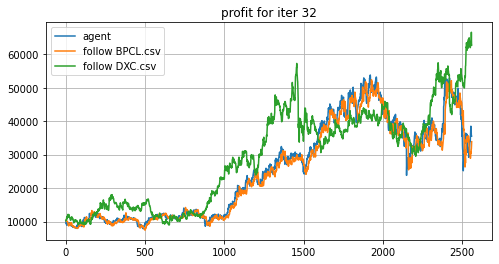

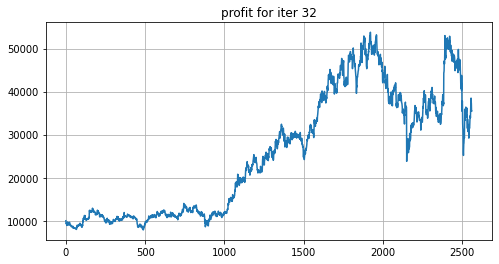

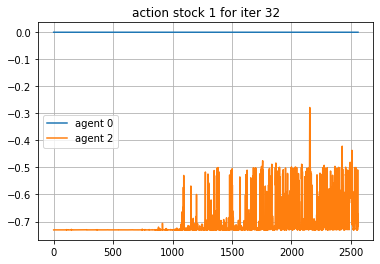

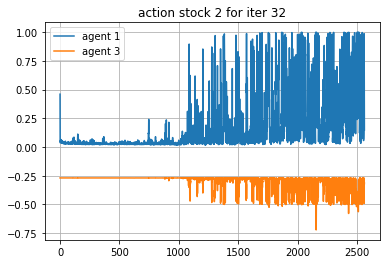

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.54430616 0.99985355 0.49293685 0.50706315]]
['M.csv' 'AMZN.csv']


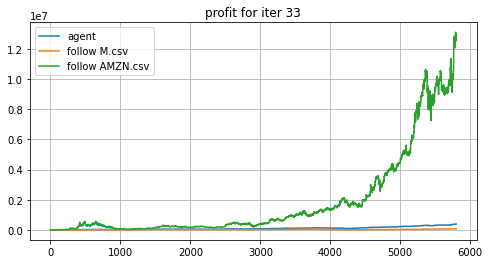

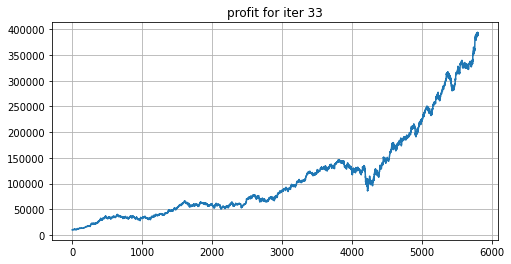

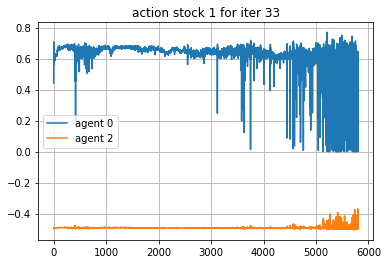

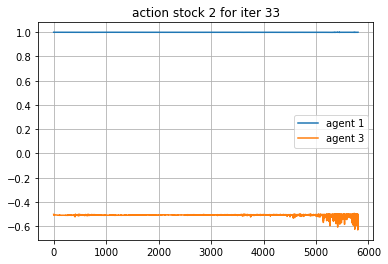

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.89974487 0.9999626  0.50008565 0.49991432]]
['INFY.csv' 'INFY.csv']


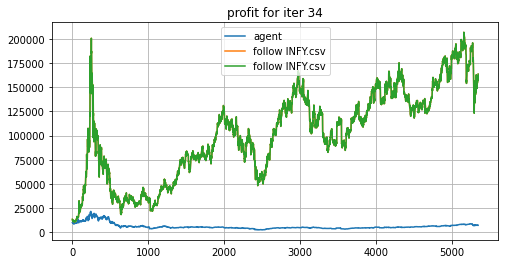

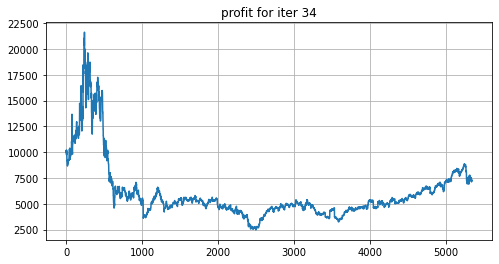

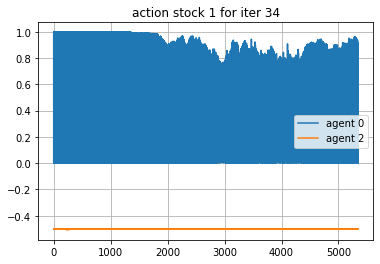

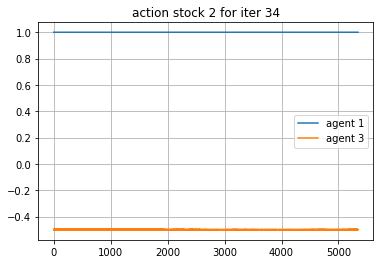

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.49720952 0.9979887  0.269133   0.730867  ]]
['PCG.csv' 'INFY.csv']


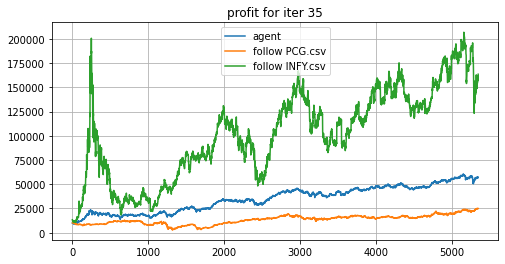

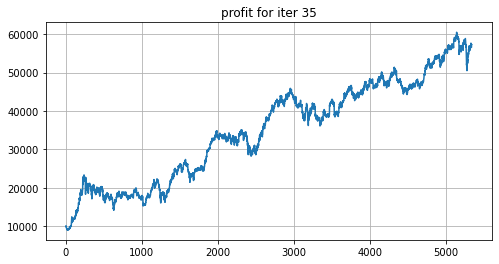

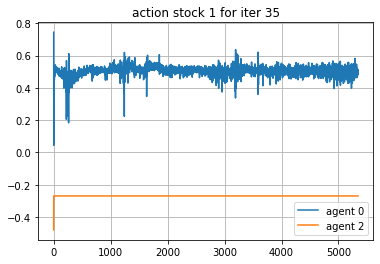

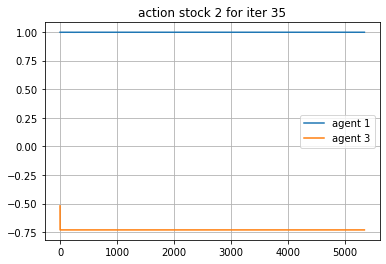

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.99160033 0.7993789  0.4984398  0.5015602 ]]
['MSFT.csv' 'PNB.csv']


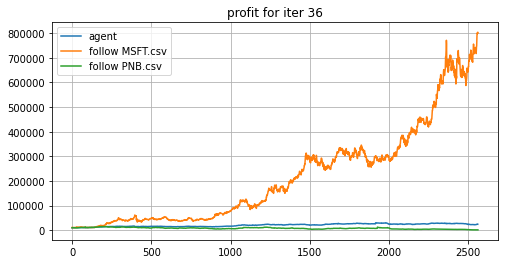

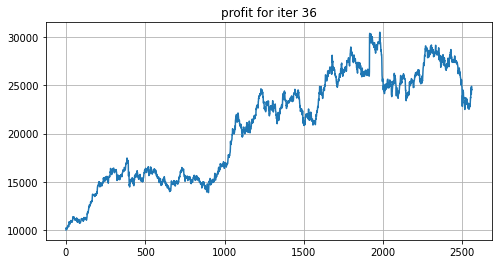

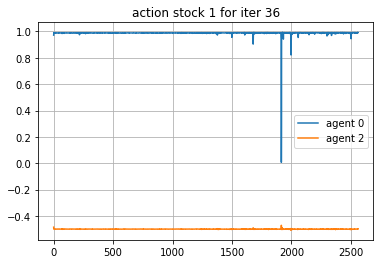

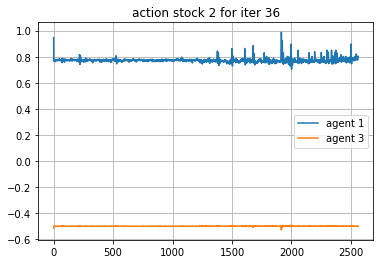

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[4.2521954e-04 3.7371814e-03 7.3017937e-01 2.6982066e-01]]
['INFY.csv' 'PNB.csv']


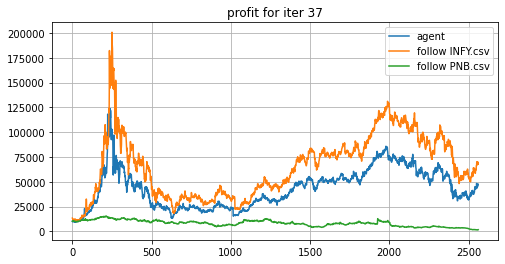

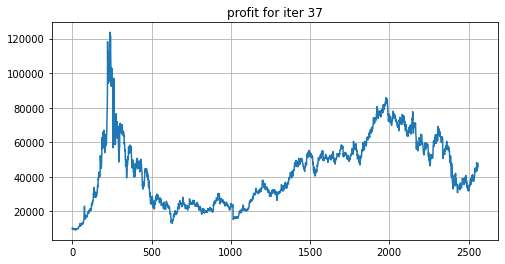

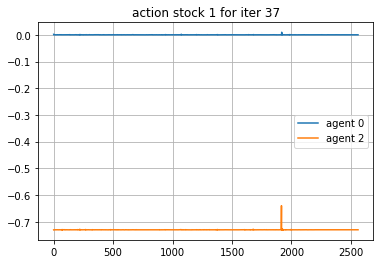

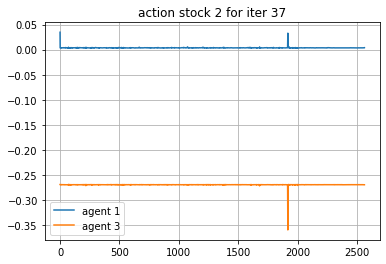

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[4.005432e-05 9.978135e-01 4.999968e-01 5.000032e-01]]
['DXC.csv' 'DXC.csv']


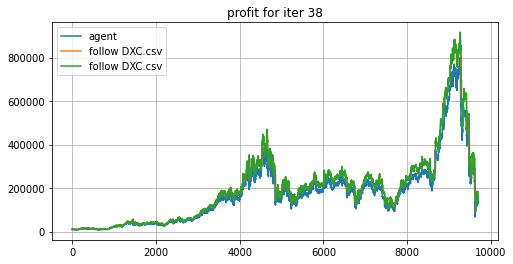

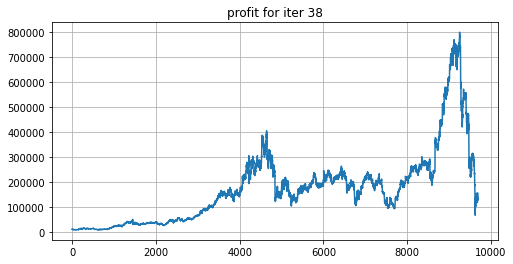

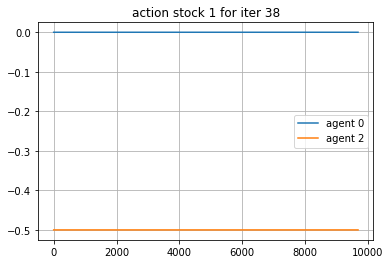

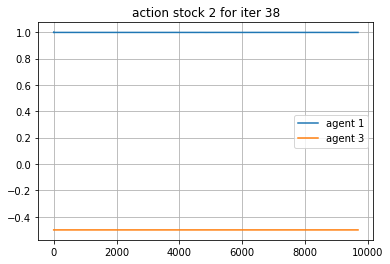

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.7881393e-07 9.9997836e-01 4.9999890e-01 5.0000113e-01]]
['M.csv' 'PCG.csv']


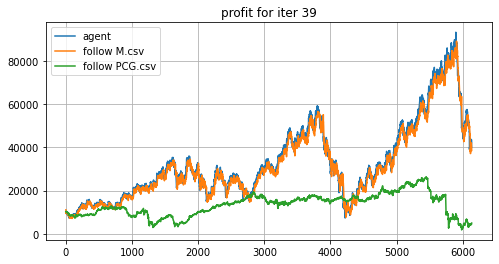

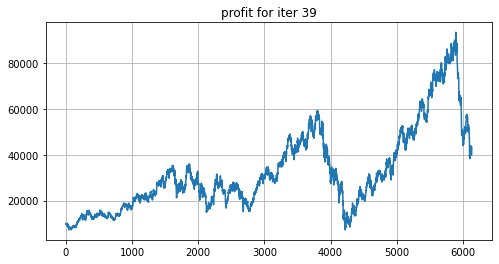

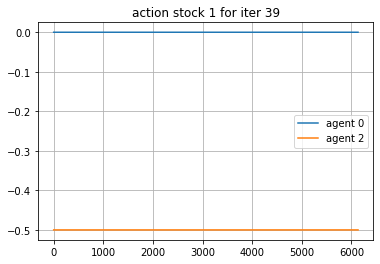

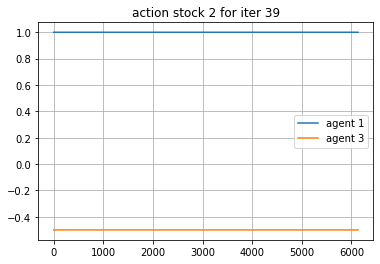

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.99642885 0.01805618 0.47608635 0.5239137 ]]
['IBM.csv' 'DXC.csv']


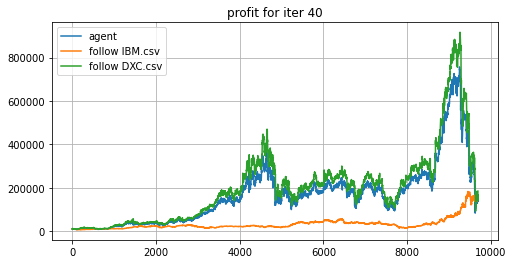

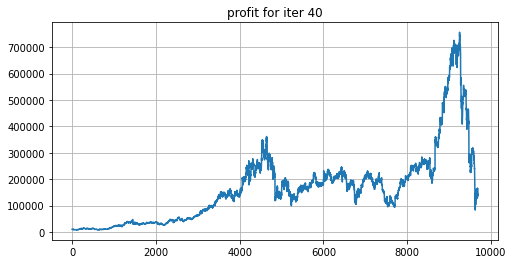

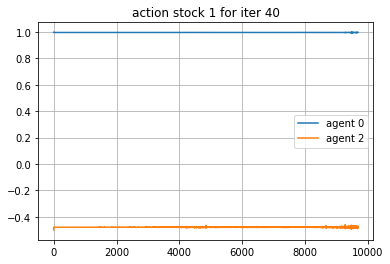

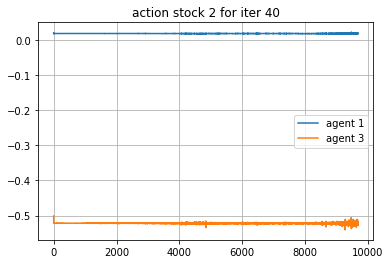

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.9802922  0.00189534 0.26955876 0.7304413 ]]
['PNB.csv' 'DXC.csv']


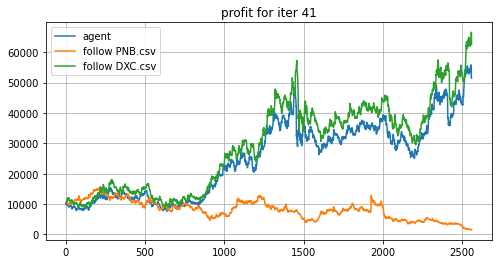

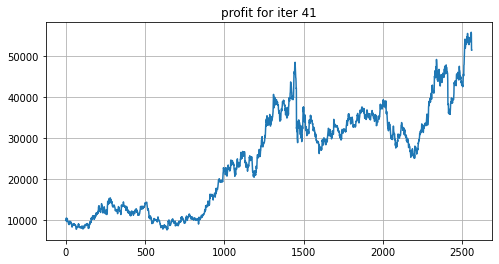

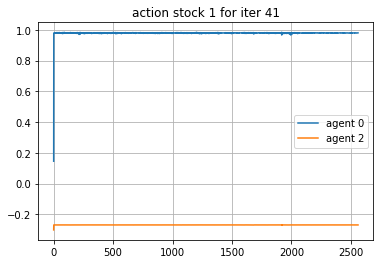

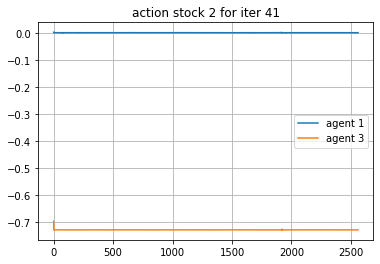

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[6.3409758e-01 3.8534403e-04 4.9999610e-01 5.0000393e-01]]
['M.csv' 'GOOG.csv']


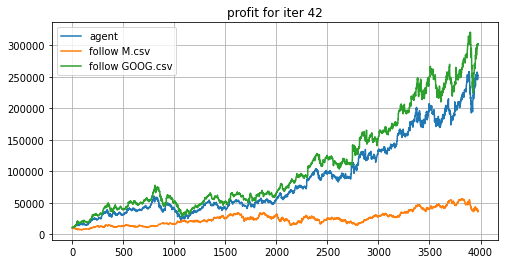

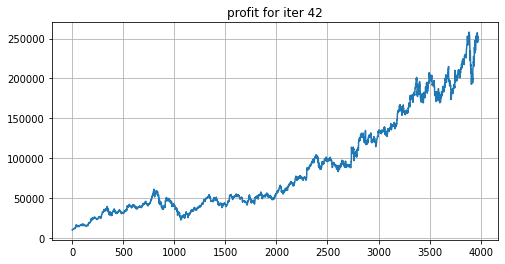

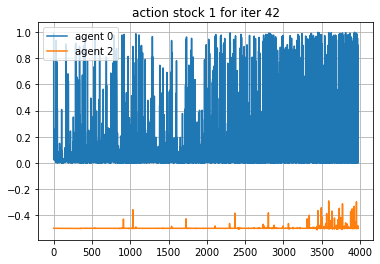

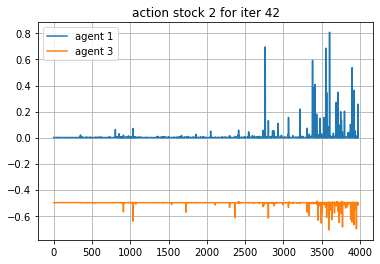

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.7251258  0.9977555  0.43499902 0.565001  ]]
['GOOG.csv' 'IBM.csv']


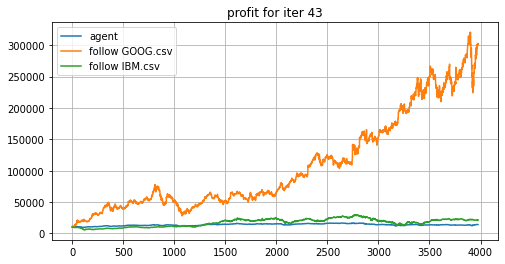

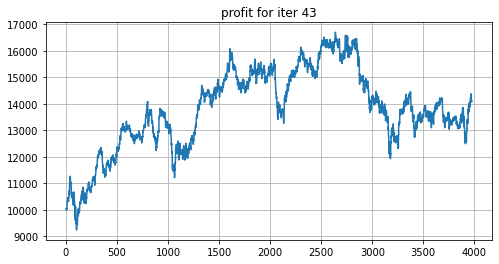

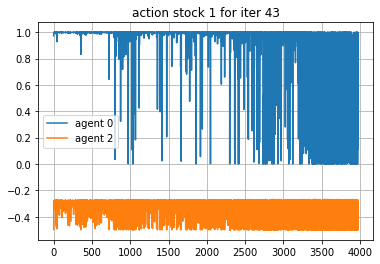

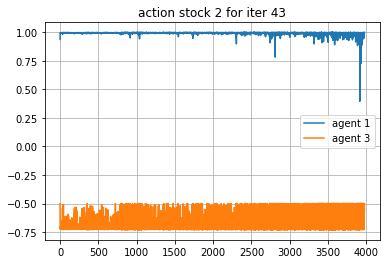

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.99996895 0.99980783 0.26898497 0.731015  ]]
['INFY.csv' 'AAPL.csv']


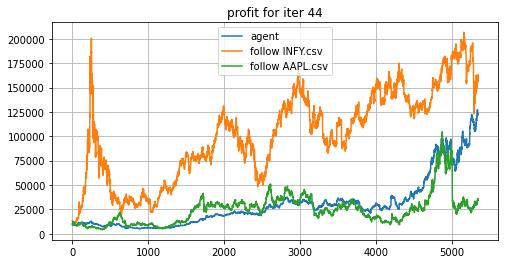

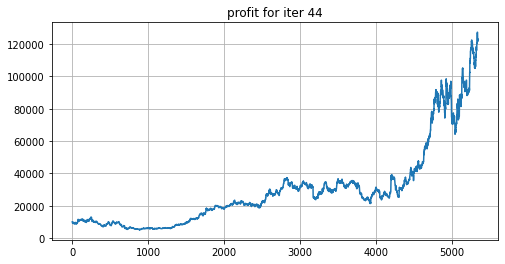

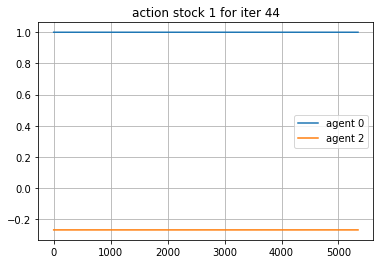

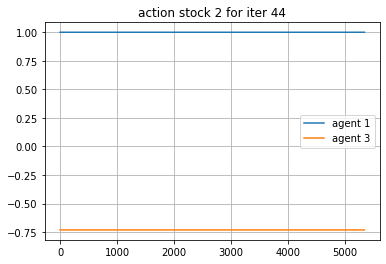

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.3561144  0.999953   0.26899508 0.73100495]]
['GOOG.csv' 'DXC.csv']


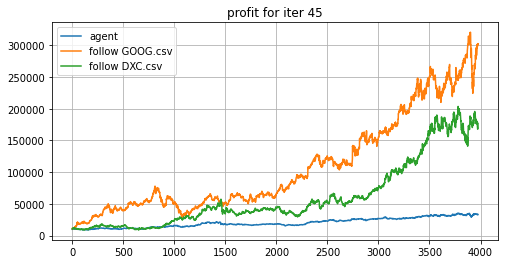

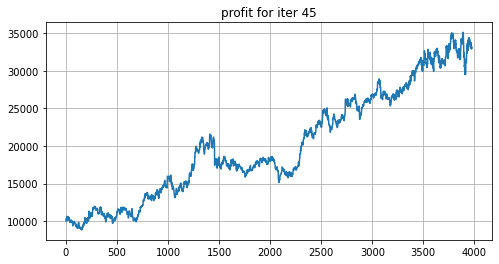

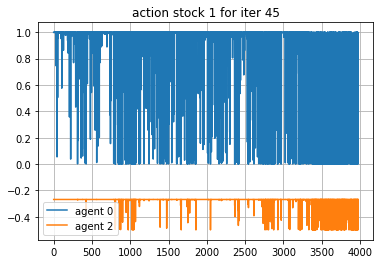

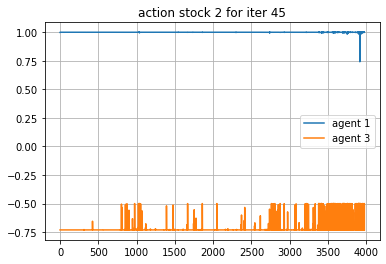

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.01905695 0.99949086 0.2689441  0.73105586]]
['PNB.csv' 'GOOG.csv']


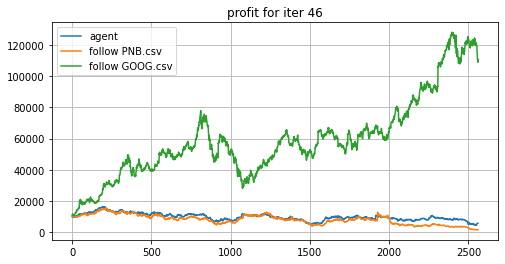

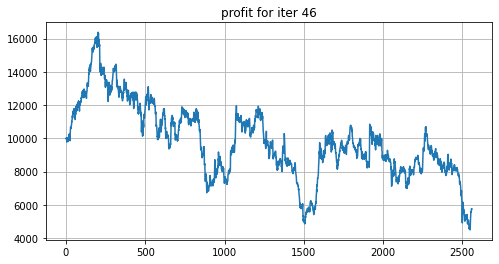

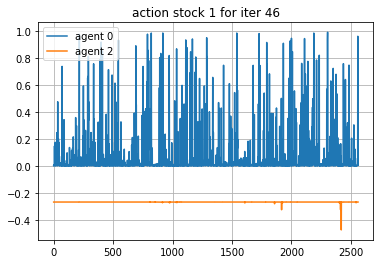

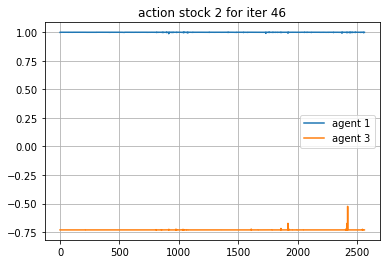

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0398258  0.9953238  0.26895538 0.73104465]]
['INFY.csv' 'PCG.csv']


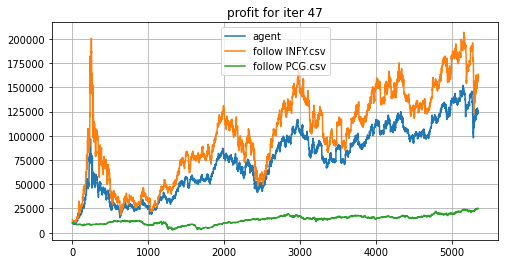

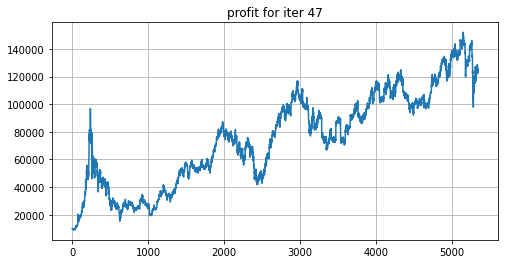

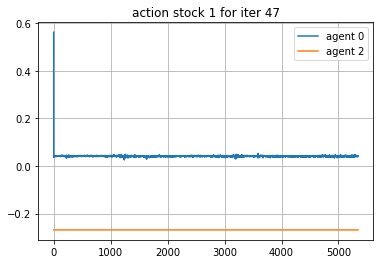

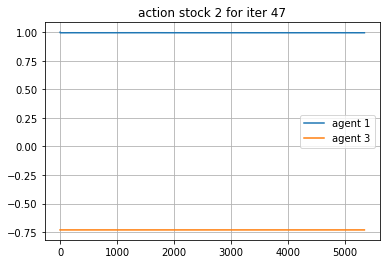

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[9.7647309e-04 9.9956656e-01 2.6894453e-01 7.3105550e-01]]
['MSFT.csv' 'DXC.csv']


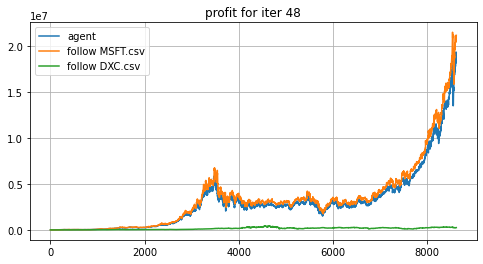

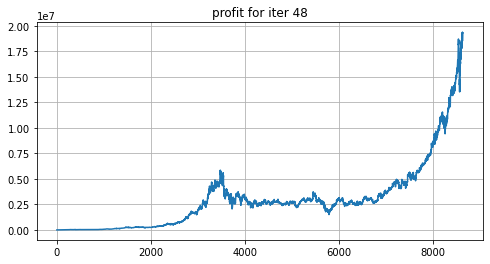

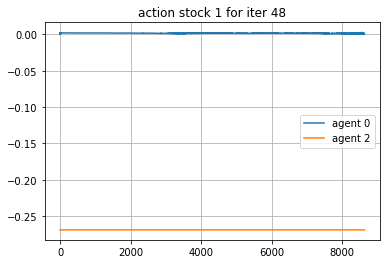

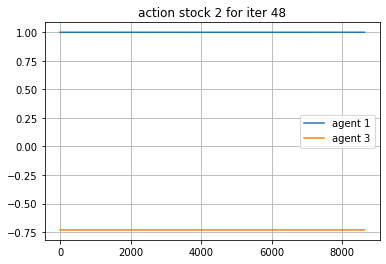

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.06801599 0.9999976  0.26894325 0.73105675]]
['AMZN.csv' 'PCG.csv']


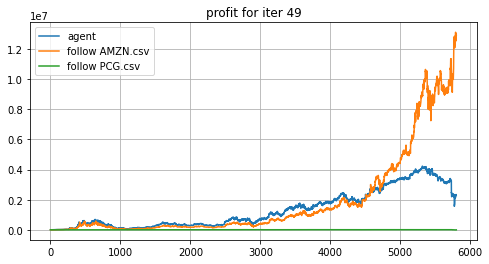

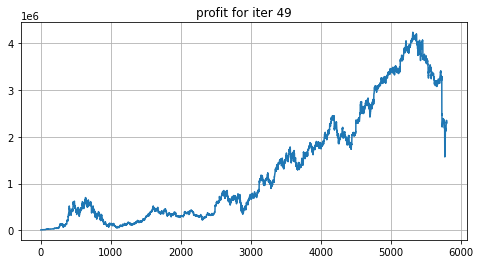

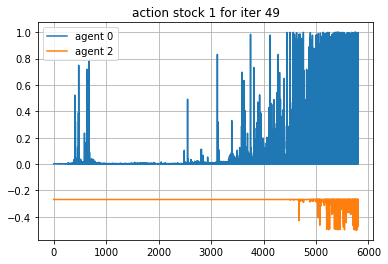

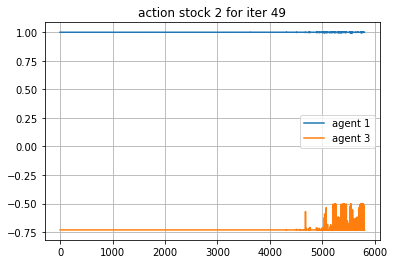

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


snap
[[2.9802322e-08 9.9996650e-01 2.6894391e-01 7.3105603e-01]]
['RELIN.csv' 'AAPL.csv']


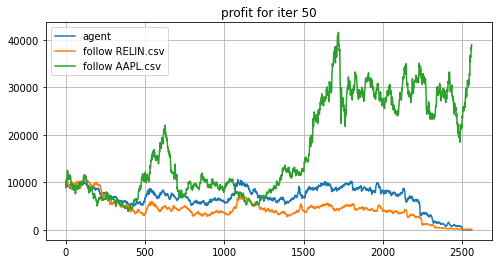

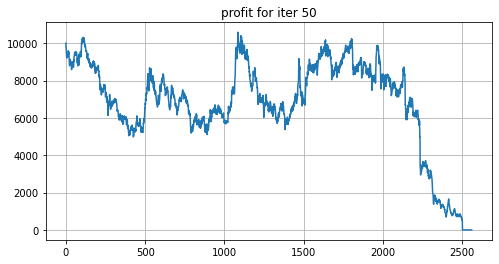

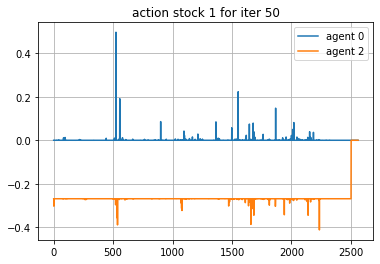

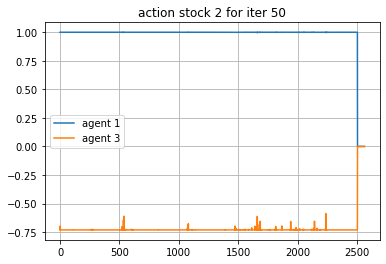

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99999845 0.26902708 0.73097295]]
['BPCL.csv' 'AMZN.csv']


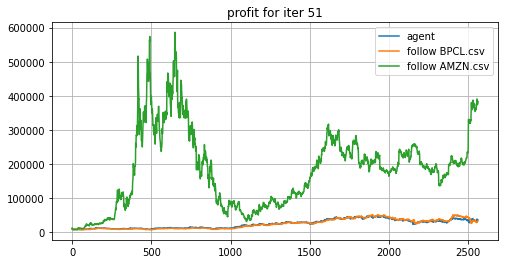

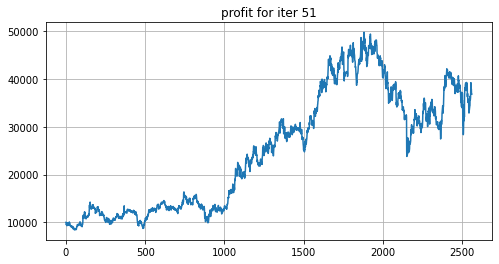

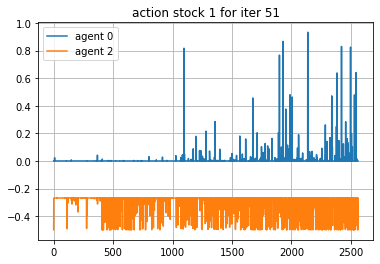

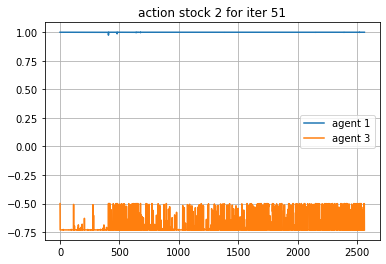

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99999964 0.49998558 0.5000144 ]]
['AMZN.csv' 'MSFT.csv']


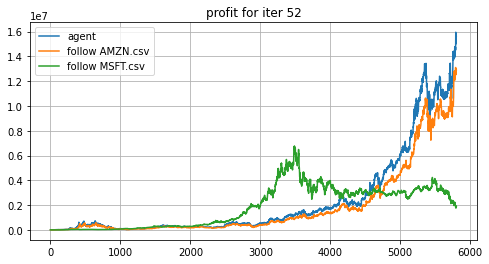

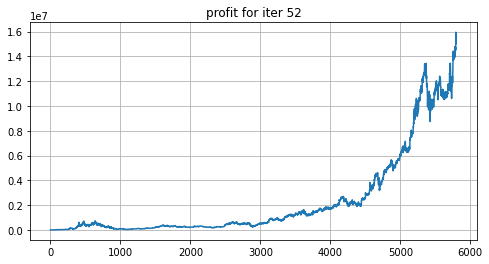

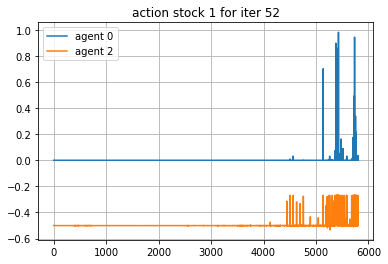

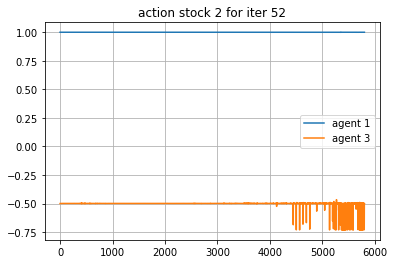

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[5.5134296e-06 1.0000000e+00 2.6894149e-01 7.3105848e-01]]
['PNB.csv' 'GOOG.csv']


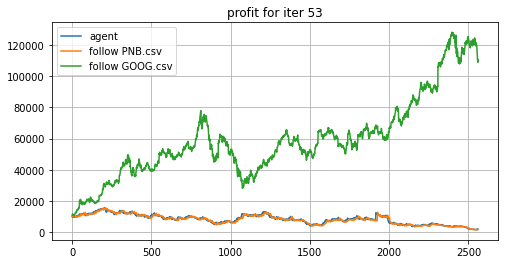

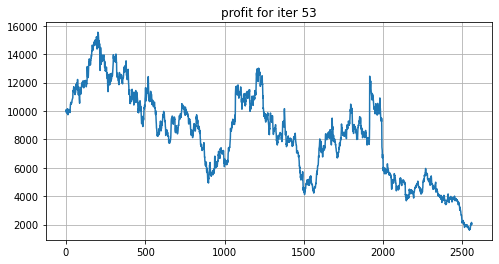

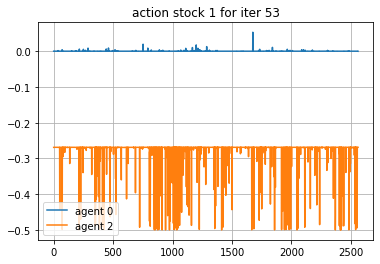

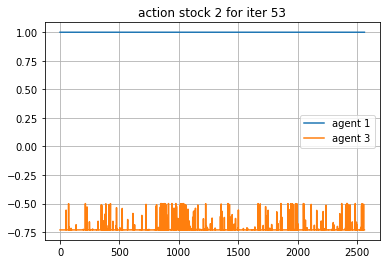

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         1.         0.26894143 0.73105854]]
['PCG.csv' 'M.csv']


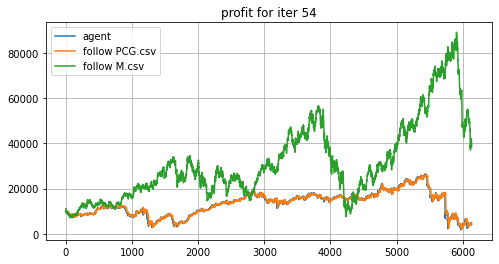

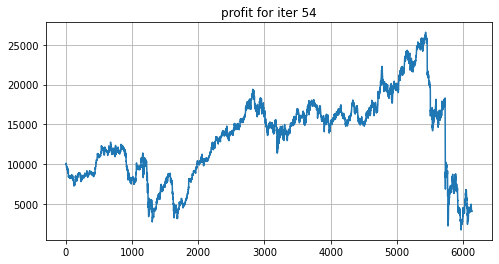

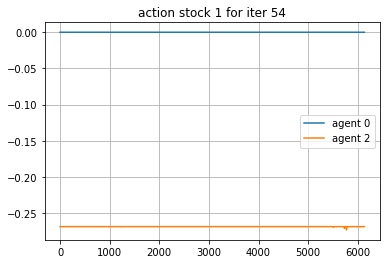

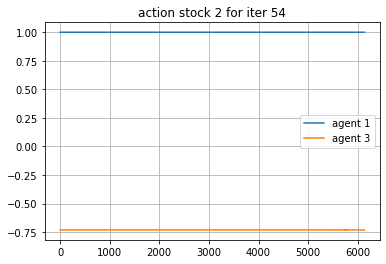

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.9999997  0.5260473  0.47395274]]
['DXC.csv' 'AAPL.csv']


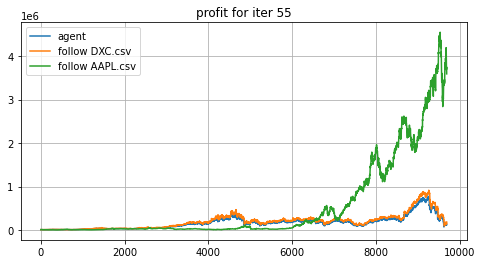

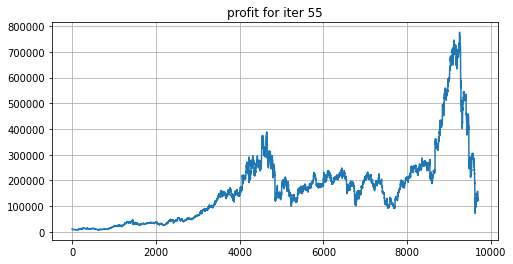

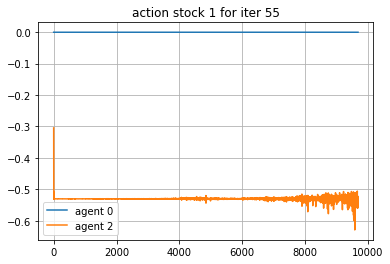

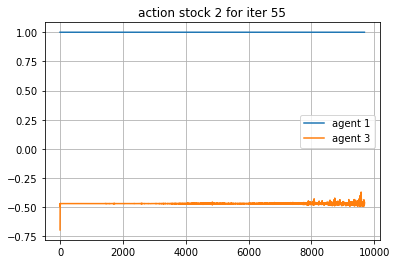

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[4.1723251e-07 1.0000000e+00 2.6894113e-01 7.3105419e-01]]
['AMZN.csv' 'DXC.csv']


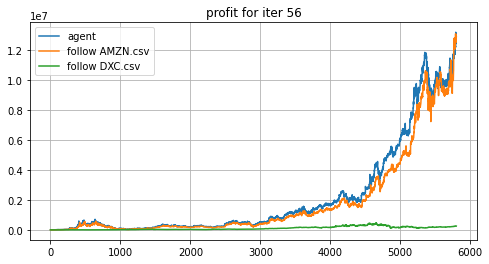

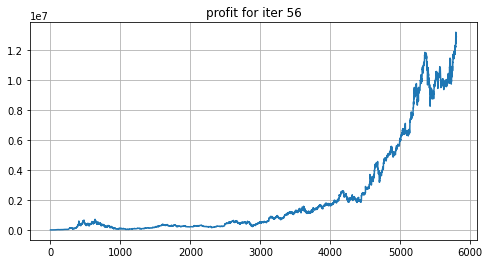

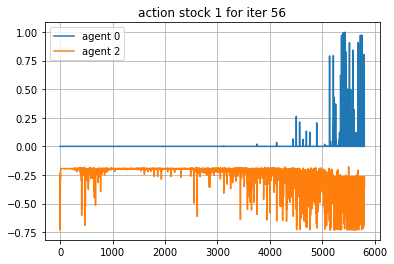

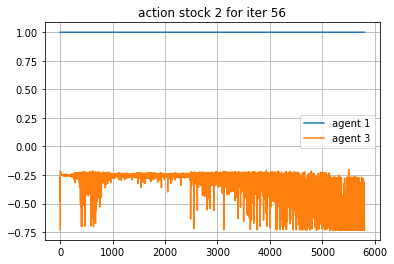

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.75308365 1.         0.26894167 0.731057  ]]
['GOOG.csv' 'INFY.csv']


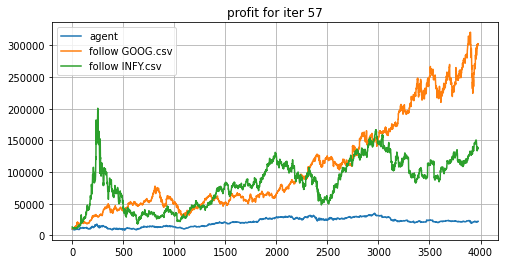

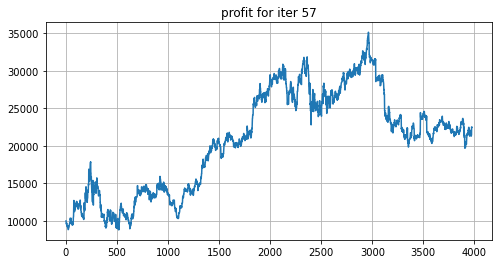

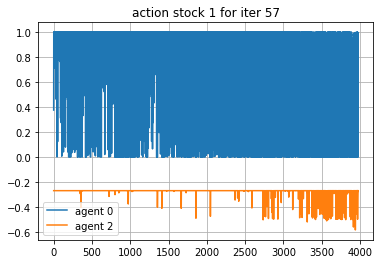

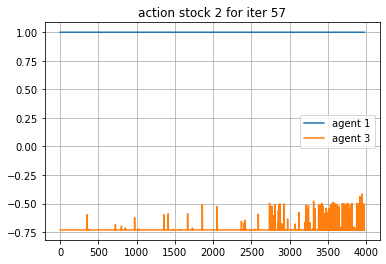

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.99773765 0.9999999  0.6500634  0.27647835]]
['M.csv' 'INFY.csv']


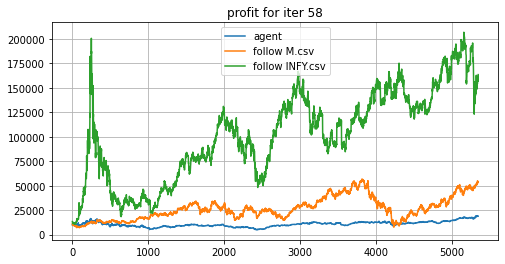

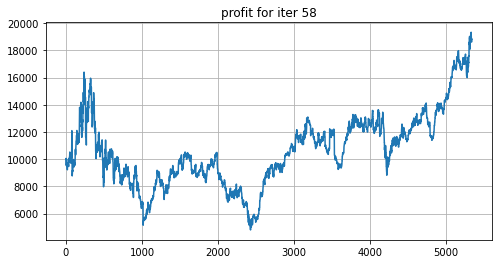

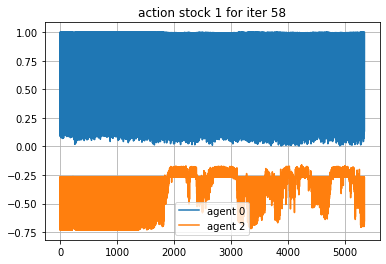

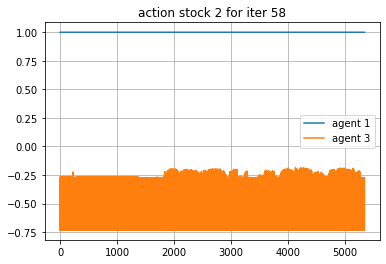

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.9999714  1.         0.2689415  0.73105854]]
['GOOG.csv' 'BPCL.csv']


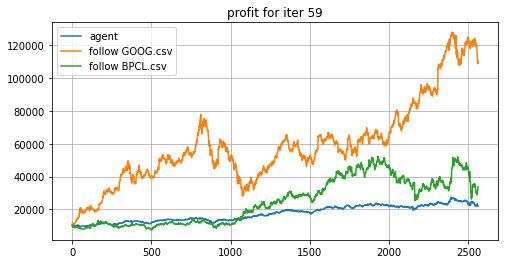

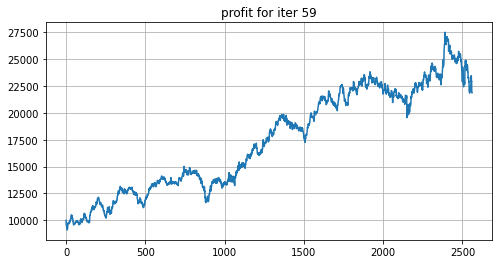

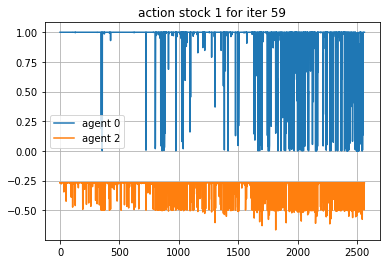

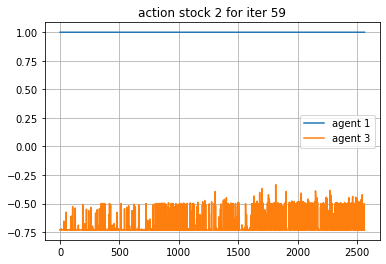

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.9999991 1.        0.149086  0.2143105]]
['INFY.csv' 'INFY.csv']


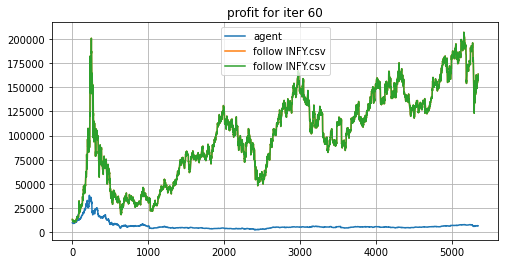

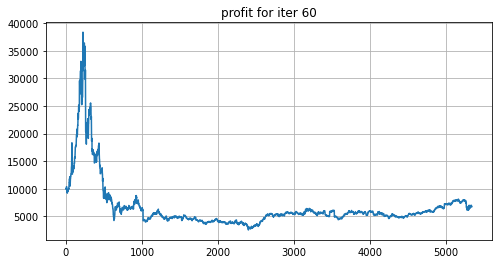

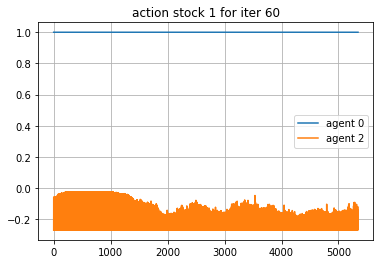

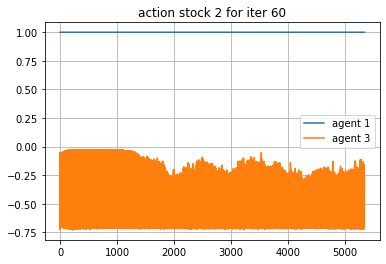

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.9999977  1.         0.26894084 0.7310509 ]]
['PCG.csv' 'DXC.csv']


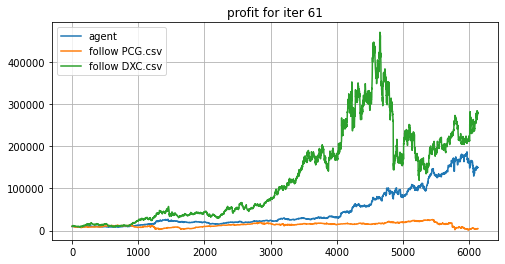

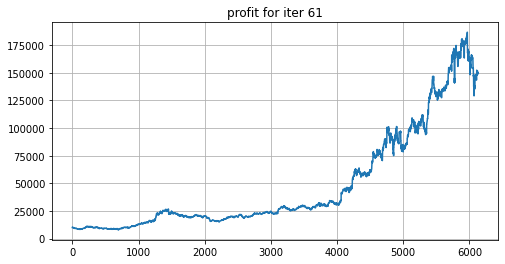

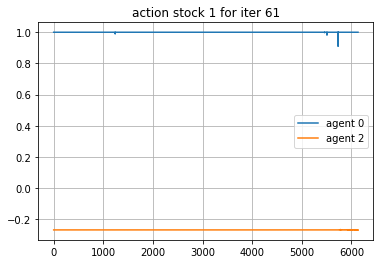

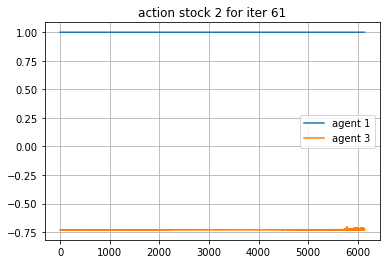

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.        1.        0.2689406 0.731048 ]]
['RELIN.csv' 'MSFT.csv']


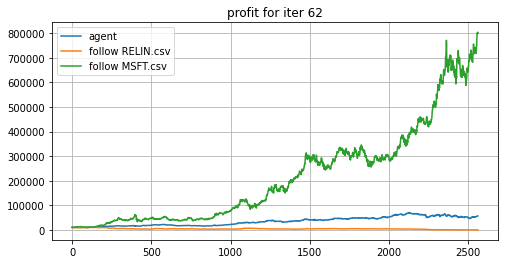

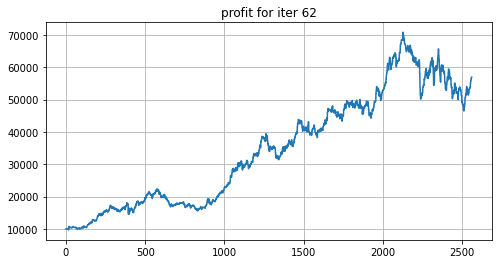

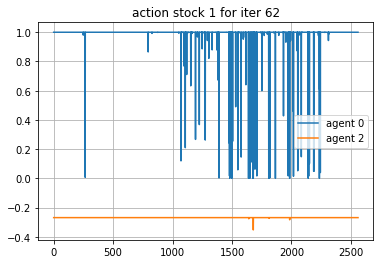

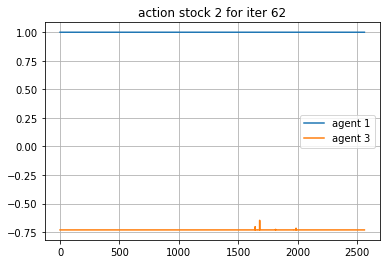

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.998208   1.         0.49800295 0.501997  ]]
['AMZN.csv' 'BPCL.csv']


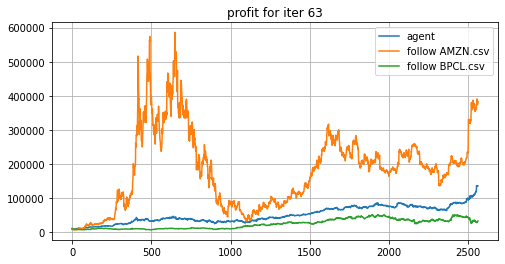

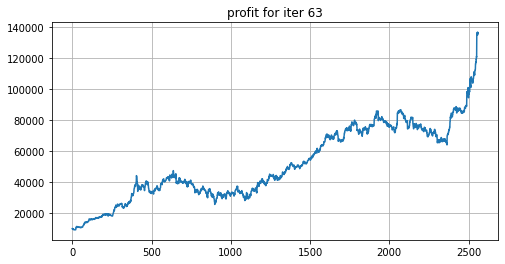

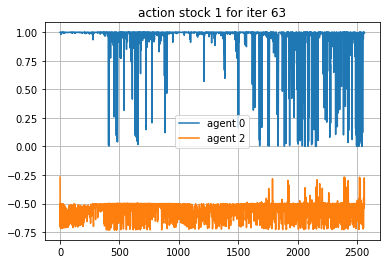

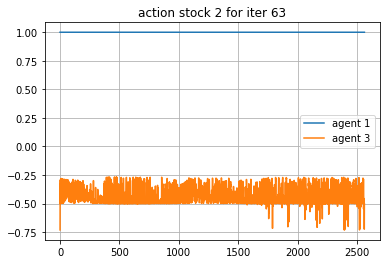

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.1146069e-05 9.9999994e-01 5.0001109e-01 4.9998894e-01]]
['BPCL.csv' 'PNB.csv']


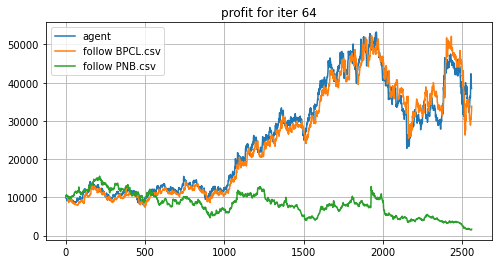

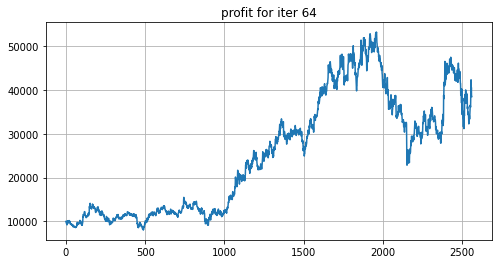

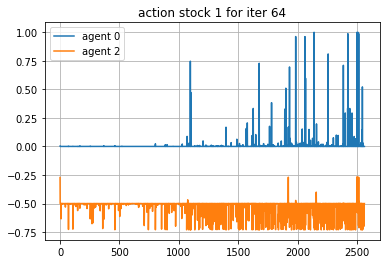

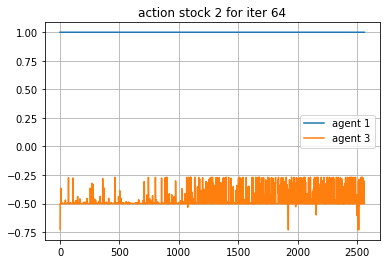

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.00356606 1.         0.26894155 0.7310585 ]]
['IBM.csv' 'AMZN.csv']


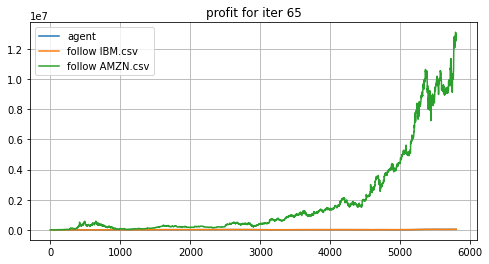

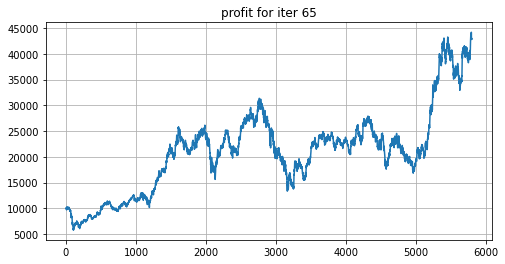

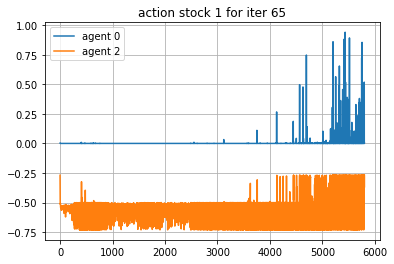

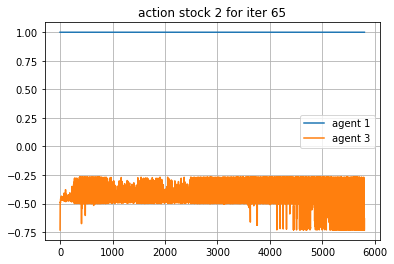

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.        1.        0.4999994 0.5000006]]
['MSFT.csv' 'RELIN.csv']


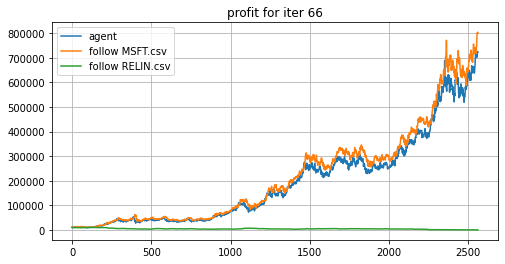

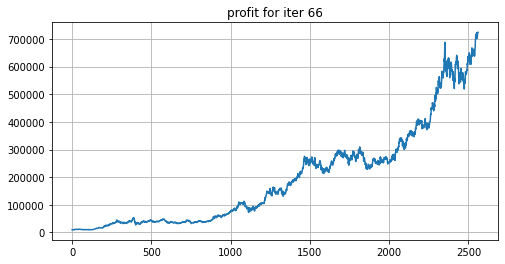

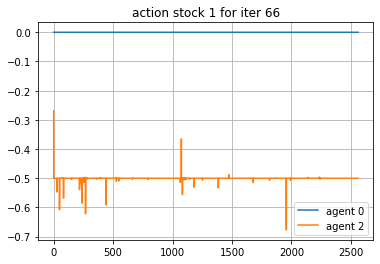

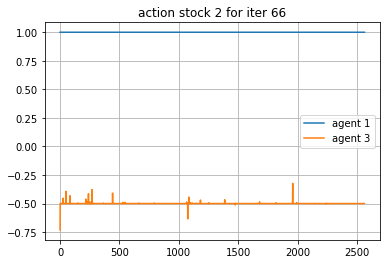

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[2.0861626e-07 1.0000000e+00 2.6894242e-01 7.3105758e-01]]
['PCG.csv' 'AAPL.csv']


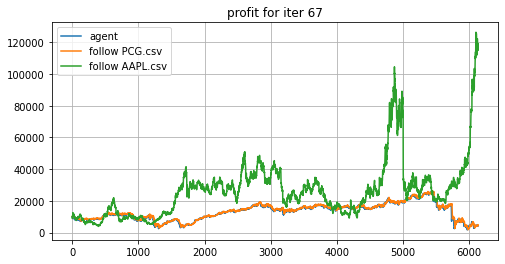

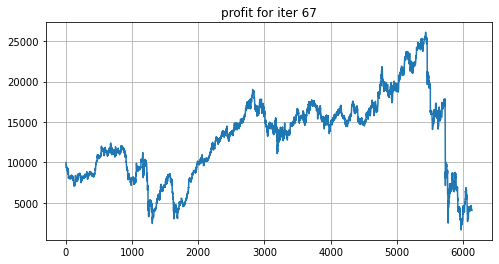

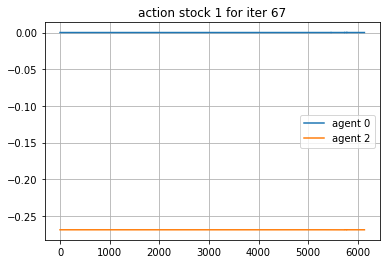

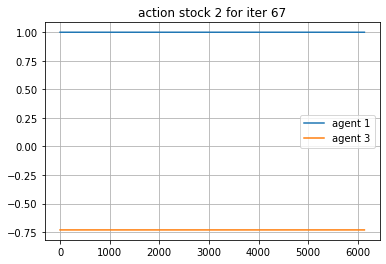

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         1.         0.49998522 0.5000148 ]]
['GOOG.csv' 'IBM.csv']


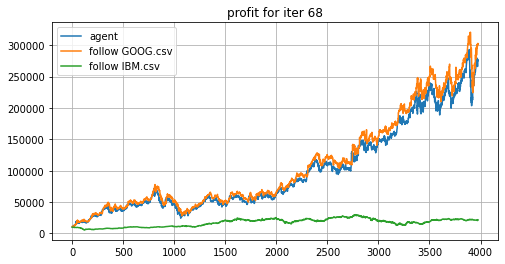

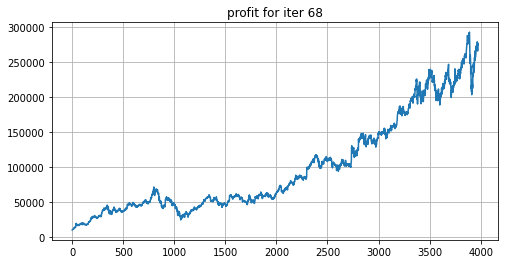

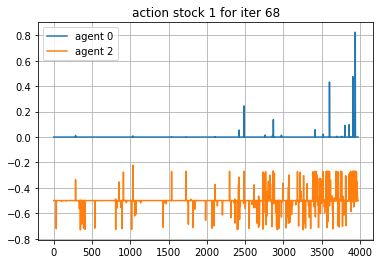

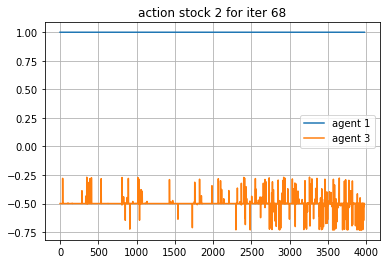

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99999005 0.5942629  0.40573713]]
['AMZN.csv' 'BPCL.csv']


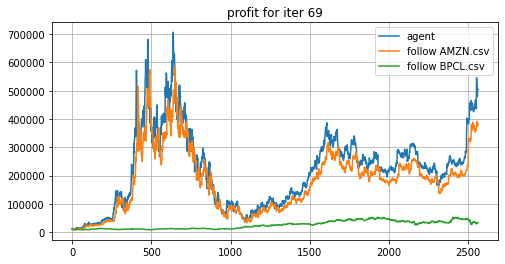

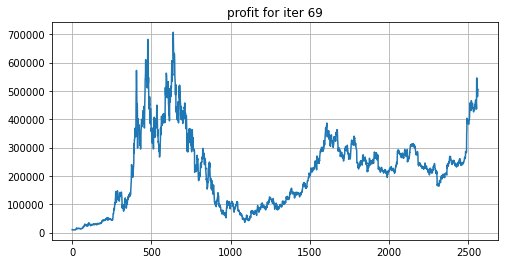

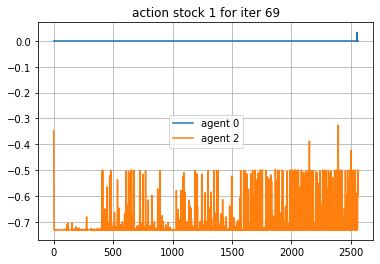

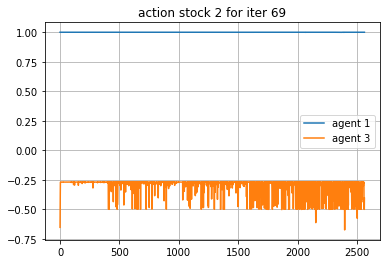

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.1920929e-07 3.4816861e-03 6.1835521e-01 3.8164482e-01]]
['INFY.csv' 'RELIN.csv']


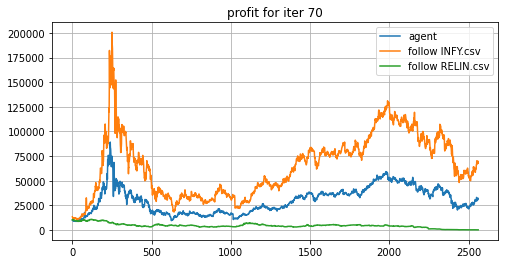

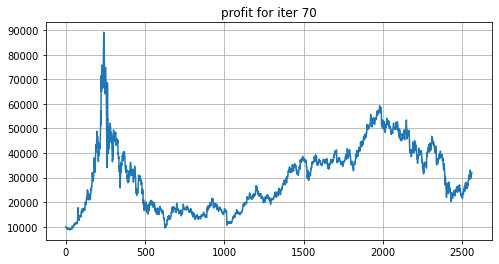

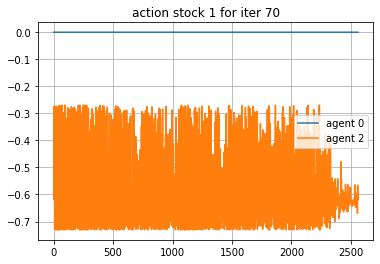

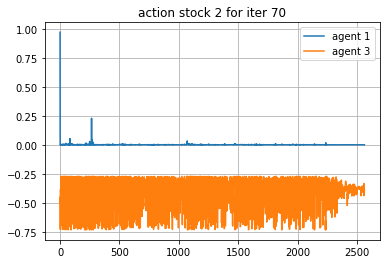

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.9985819  0.49997213 0.50002784]]
['PCG.csv' 'BPCL.csv']


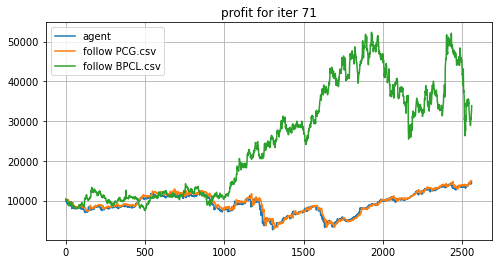

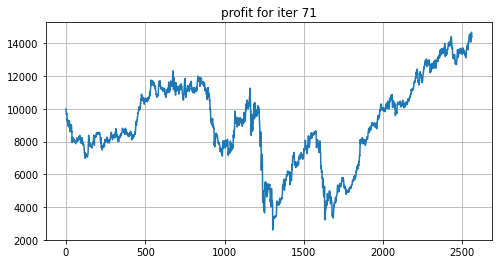

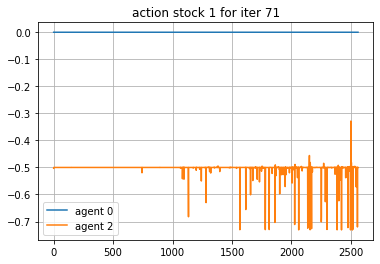

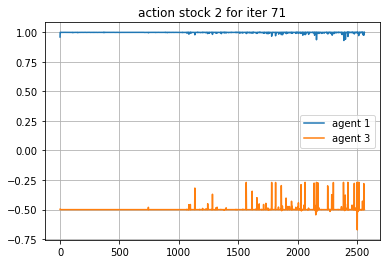

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.00380397 0.4999934  0.5000066 ]]
['PCG.csv' 'RELIN.csv']


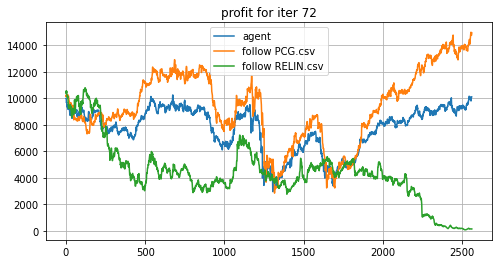

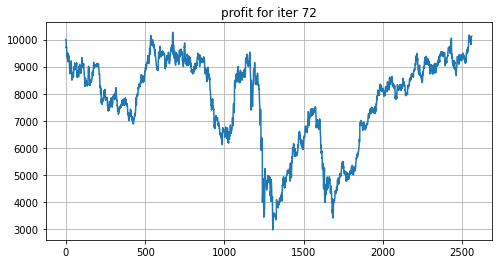

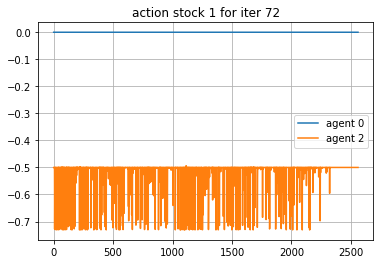

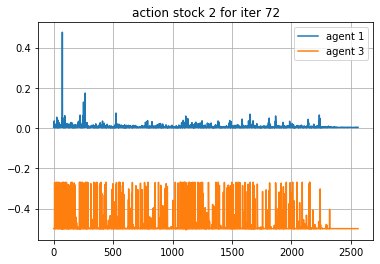

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[2.9802322e-07 9.9999976e-01 5.1928079e-01 4.8071921e-01]]
['PCG.csv' 'AMZN.csv']


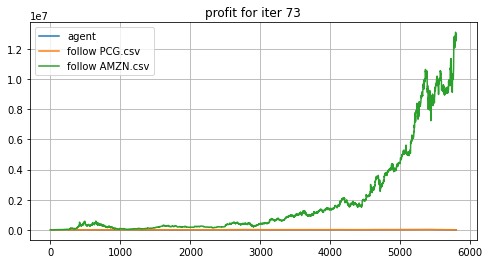

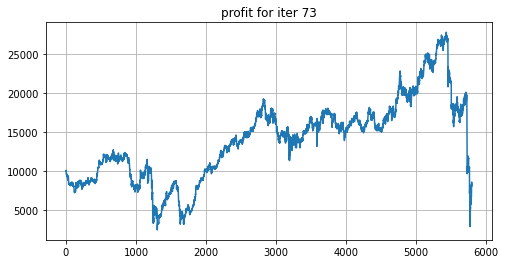

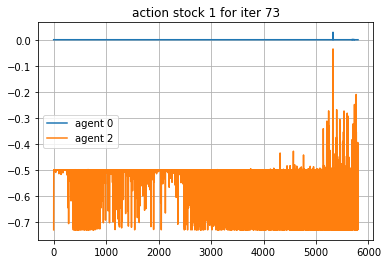

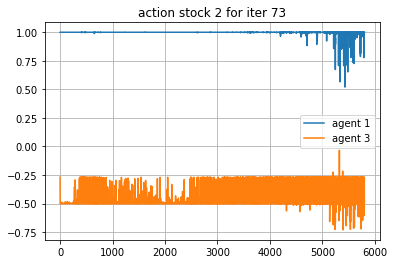

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.        0.9999963 0.4999964 0.5000036]]
['PCG.csv' 'INFY.csv']


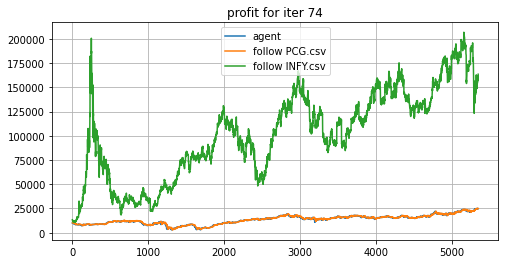

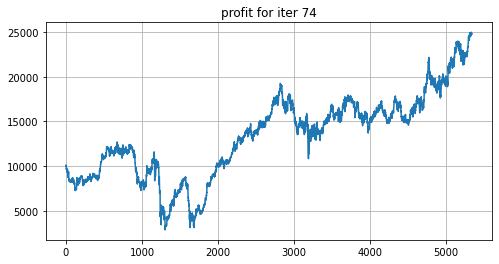

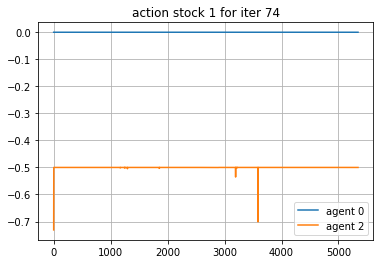

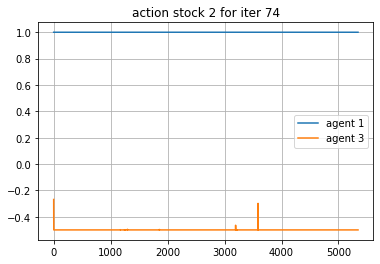

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         1.         0.34910375 0.65089625]]
['INFY.csv' 'AAPL.csv']


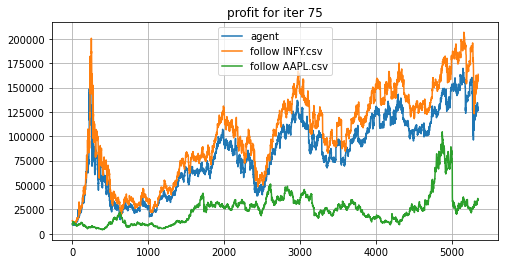

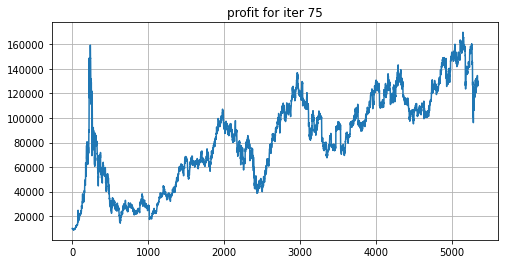

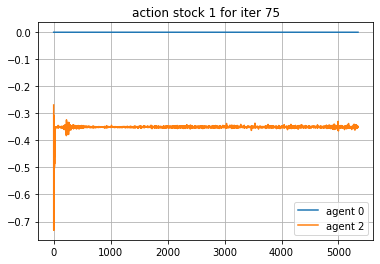

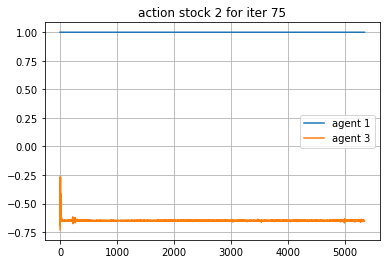

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.        0.9999528 0.2689456 0.7310544]]
['M.csv' 'IBM.csv']


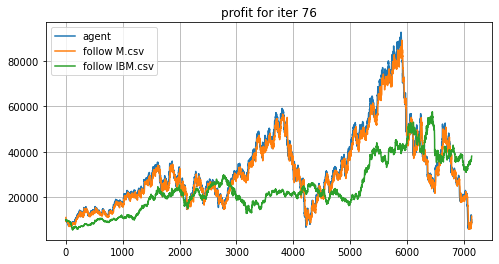

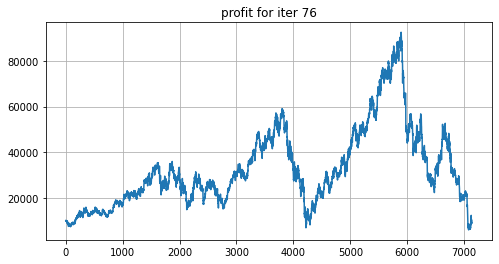

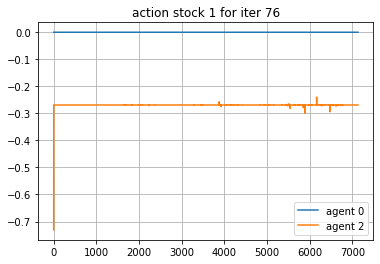

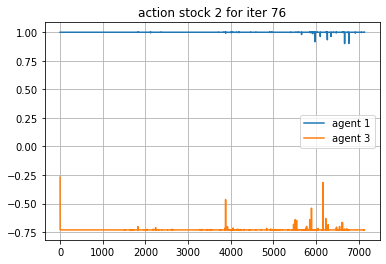

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[2.9802322e-08 9.9999946e-01 2.6894143e-01 7.3105860e-01]]
['BPCL.csv' 'RELIN.csv']


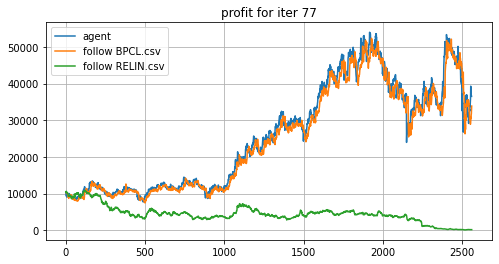

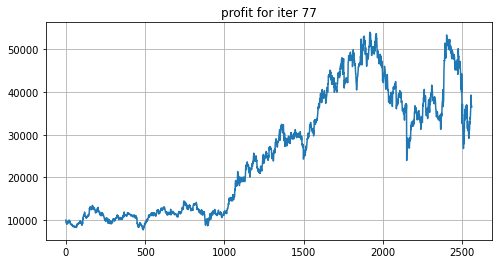

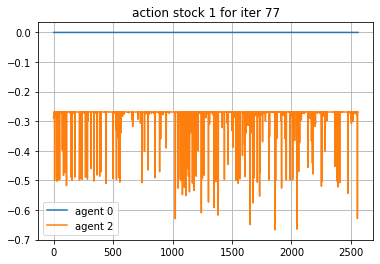

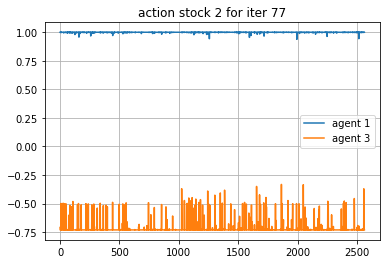

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.9380637  0.49135774 0.5086423 ]]
['PCG.csv' 'MSFT.csv']


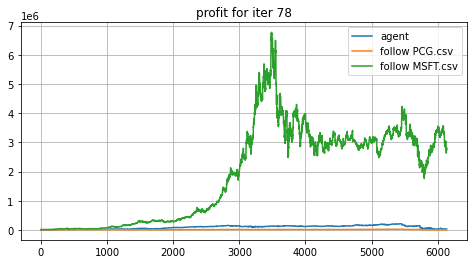

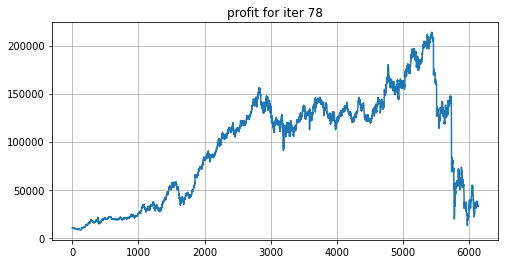

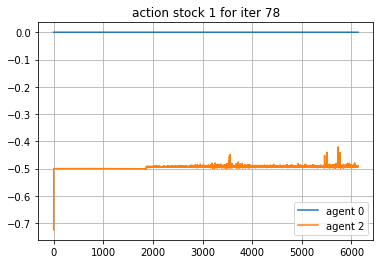

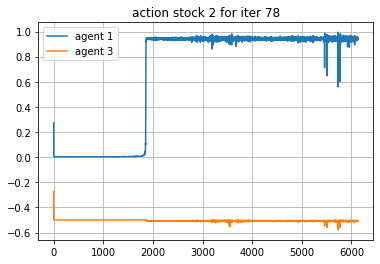

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.9999833  0.51503927 0.4849608 ]]
['INFY.csv' 'MSFT.csv']


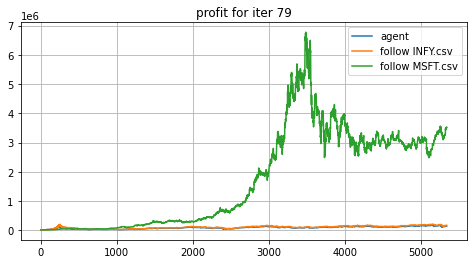

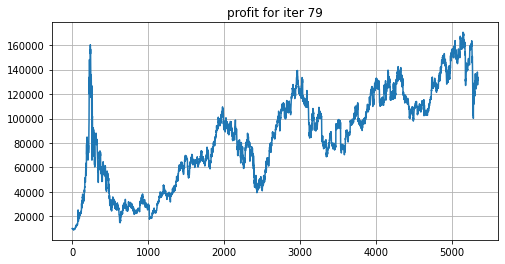

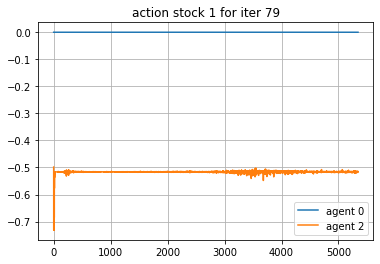

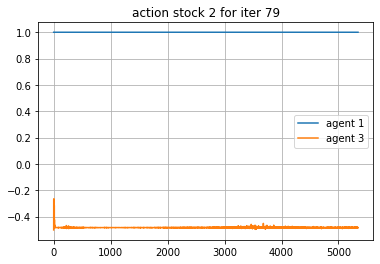

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99999666 0.73100406 0.26899588]]
['DXC.csv' 'AMZN.csv']


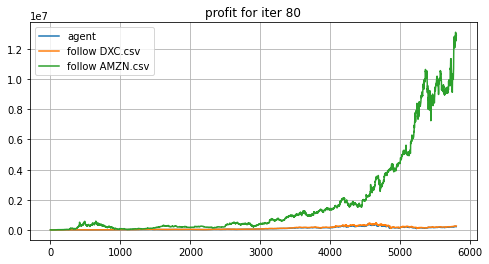

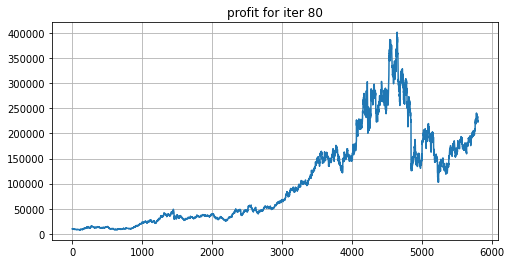

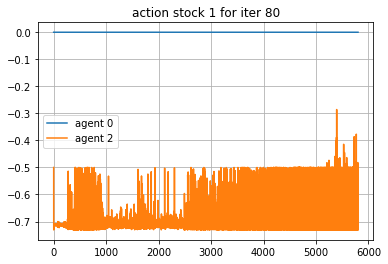

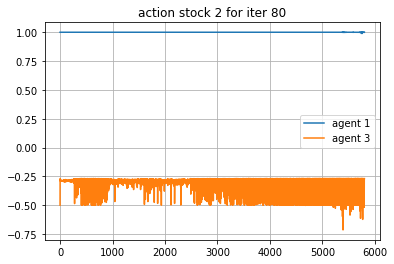

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.        0.9998575 0.4999655 0.5000345]]
['PNB.csv' 'PCG.csv']


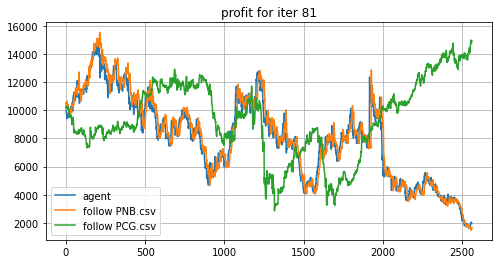

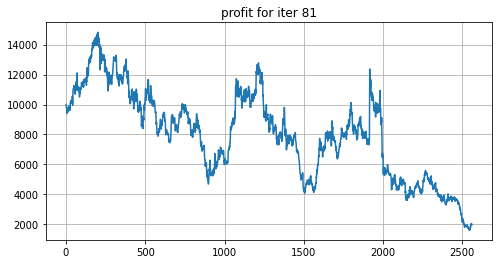

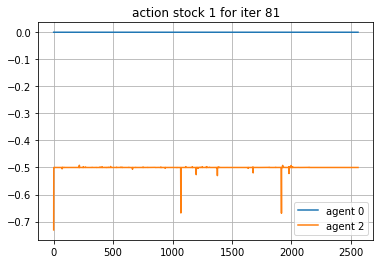

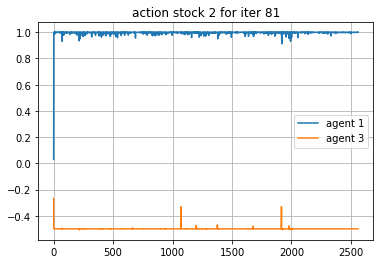

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


snap
[[0.         0.99982977 0.49997464 0.5000254 ]]
['RELIN.csv' 'BPCL.csv']


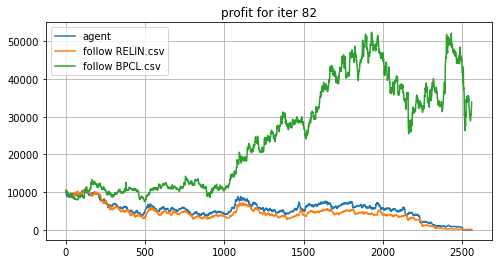

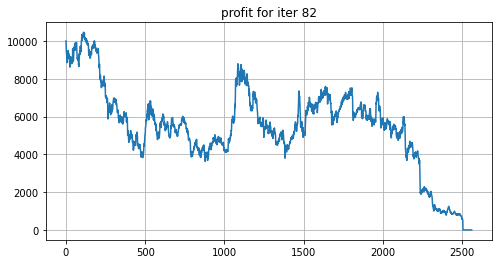

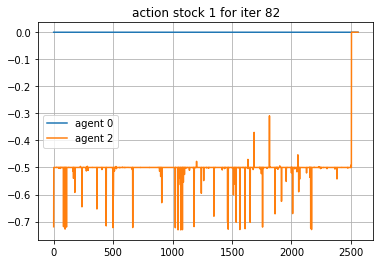

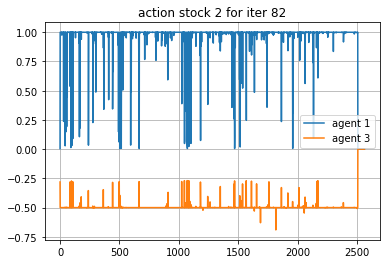

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.99999976 0.4999998  0.50000024]]
['INFY.csv' 'MSFT.csv']


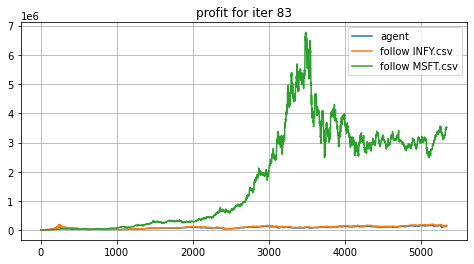

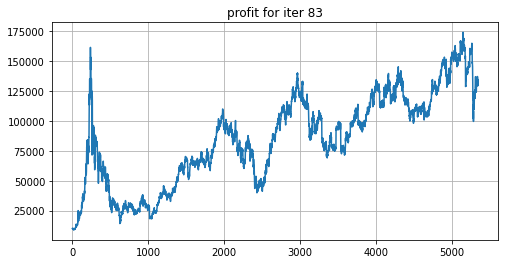

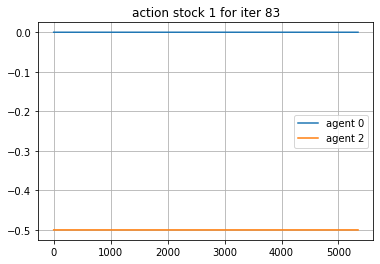

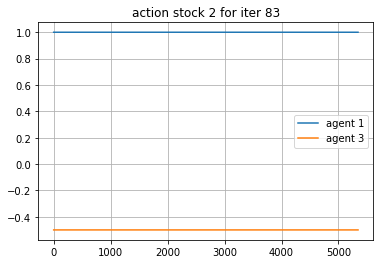

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.35644963 0.7310585  0.2689415 ]]
['AAPL.csv' 'AMZN.csv']


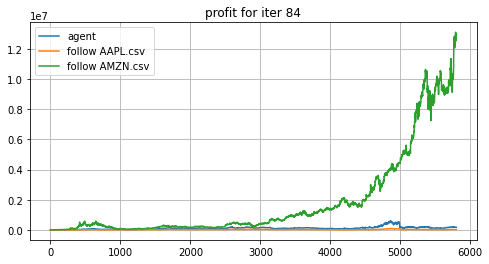

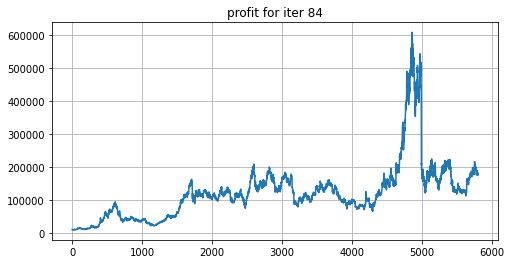

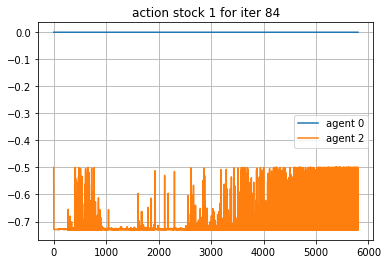

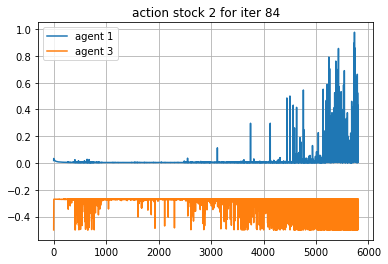

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.00067934 0.5000001  0.49999985]]
['PNB.csv' 'AAPL.csv']


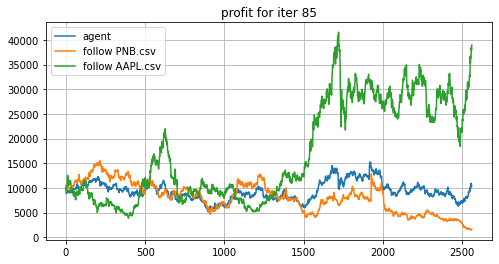

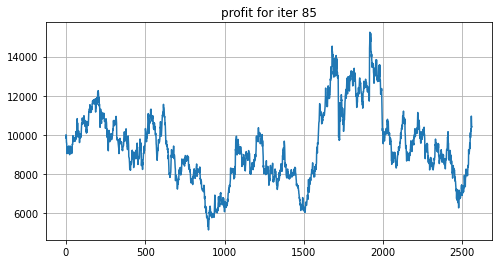

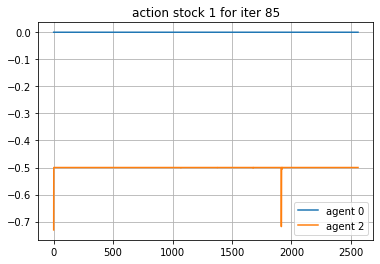

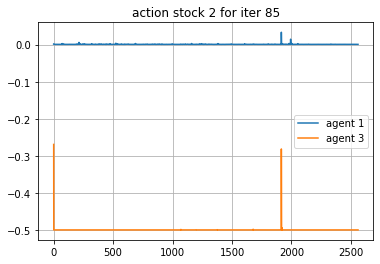

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 4.8756599e-05 7.3087668e-01 2.6912335e-01]]
['AAPL.csv' 'IBM.csv']


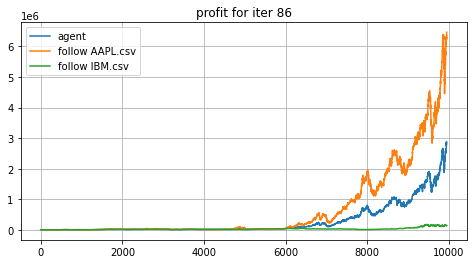

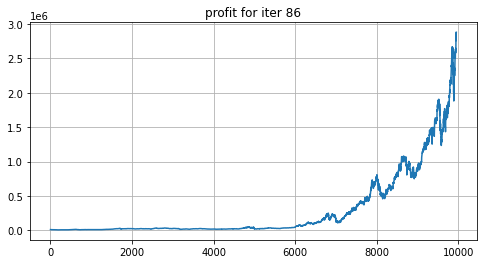

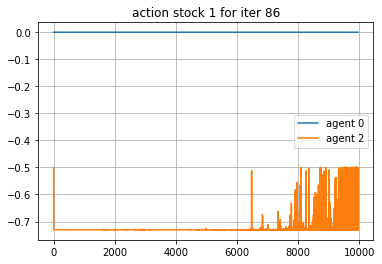

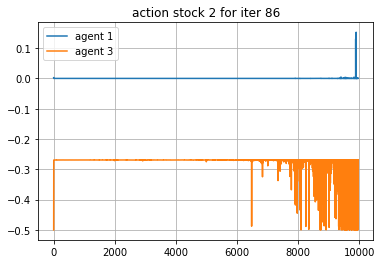

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.000000e+00 3.913045e-05 5.000000e-01 5.000000e-01]]
['PNB.csv' 'PCG.csv']


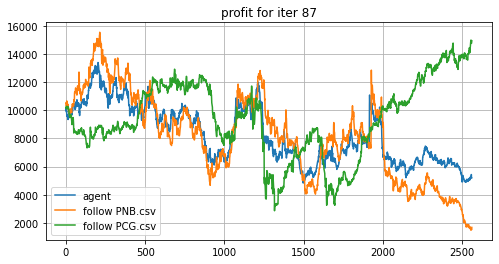

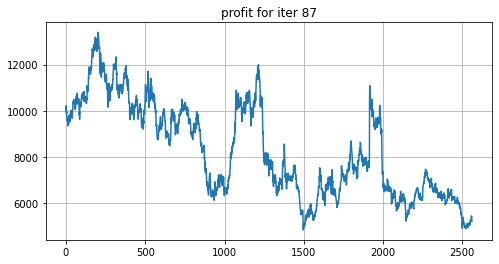

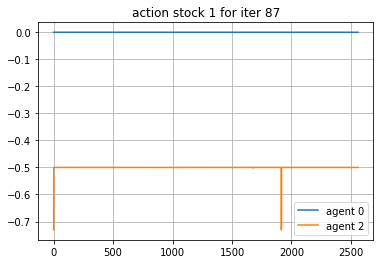

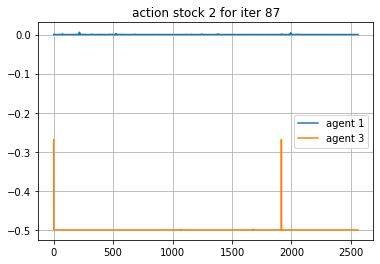

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 3.5703182e-05 5.0000000e-01 5.0000000e-01]]
['GOOG.csv' 'IBM.csv']


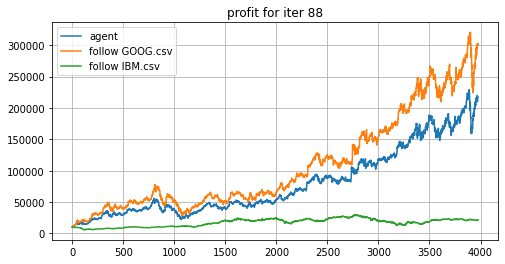

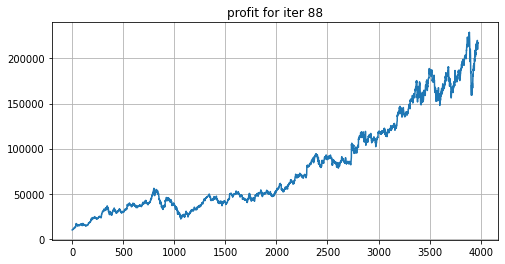

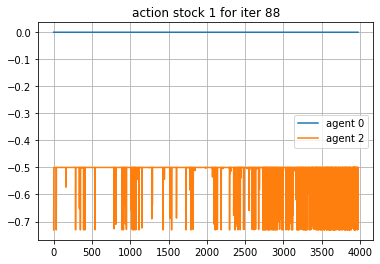

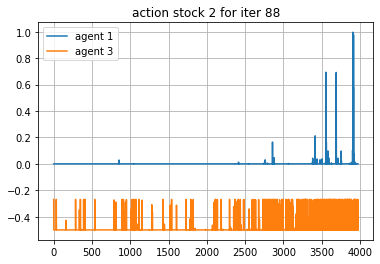

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 9.3281269e-06 7.3105854e-01 2.6894143e-01]]
['DXC.csv' 'PNB.csv']


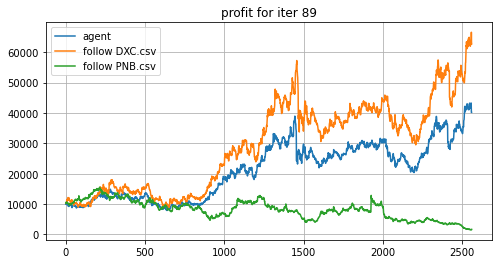

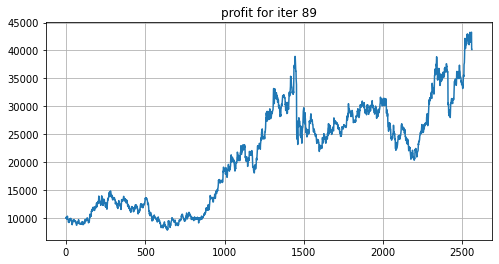

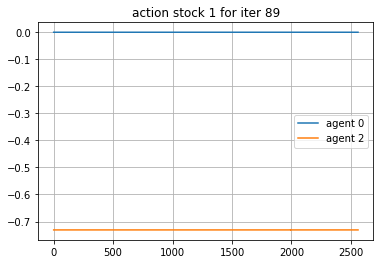

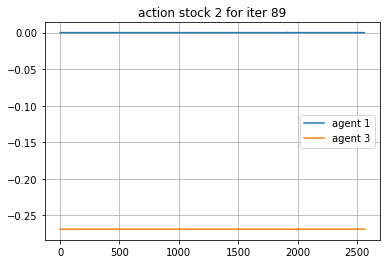

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 1.1056662e-05 7.3098040e-01 2.6901966e-01]]
['GOOG.csv' 'GOOG.csv']


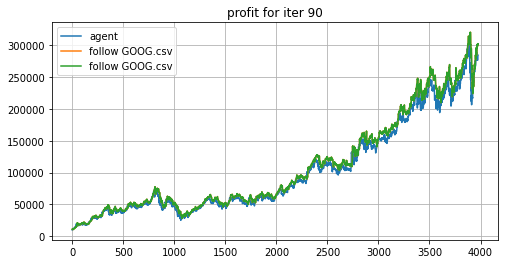

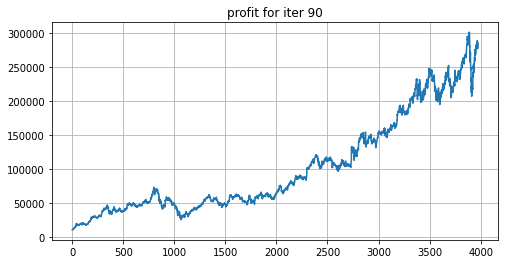

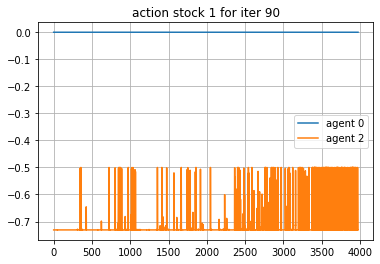

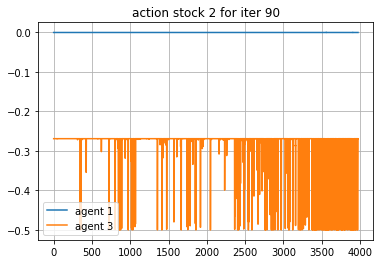

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 2.9802322e-08 7.2687256e-01 2.7312741e-01]]
['BPCL.csv' 'M.csv']


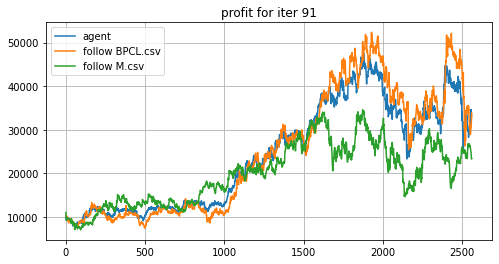

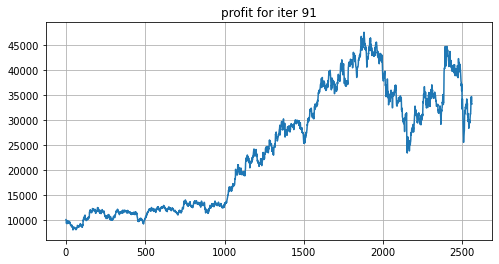

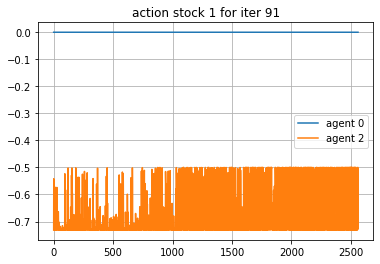

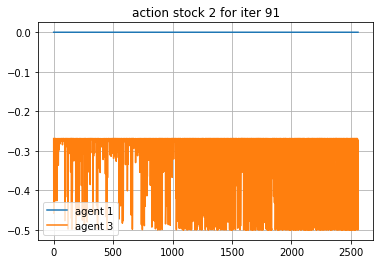

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.         0.50102    0.49897996]]
['RELIN.csv' 'AMZN.csv']


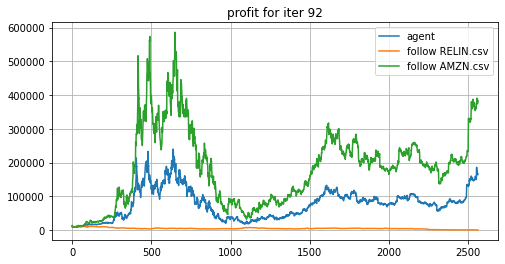

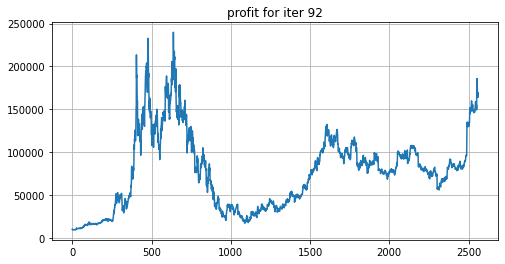

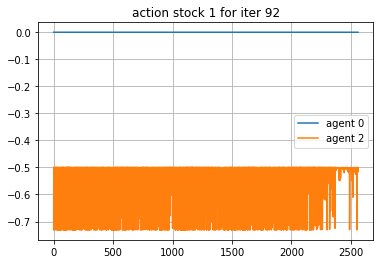

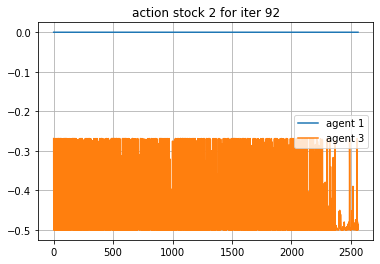

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 2.9802322e-08 7.3105854e-01 2.6894146e-01]]
['AAPL.csv' 'AMZN.csv']


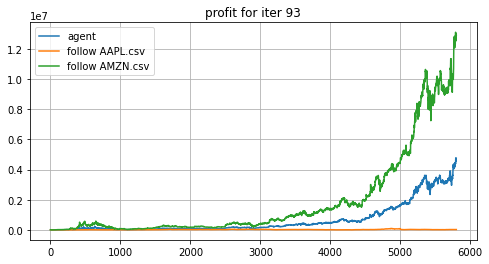

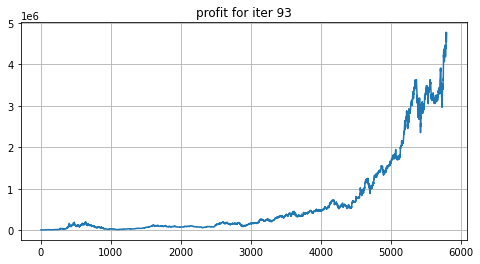

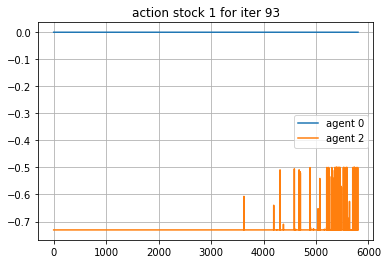

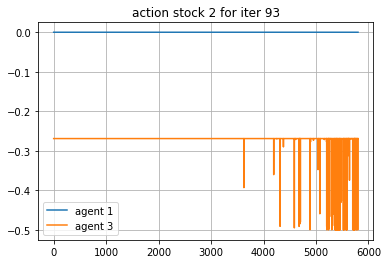

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 2.3841858e-07 7.3105842e-01 2.6894161e-01]]
['AMZN.csv' 'AMZN.csv']


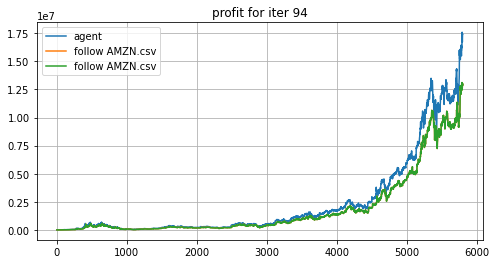

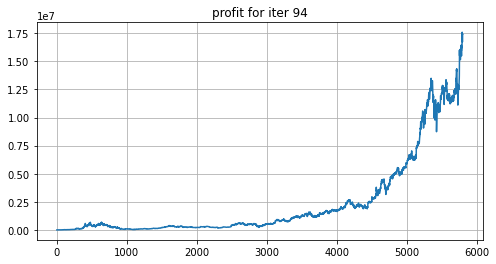

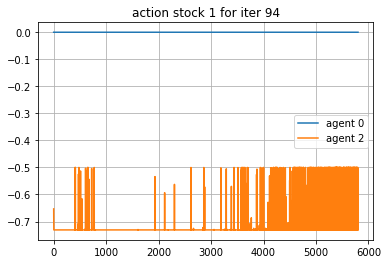

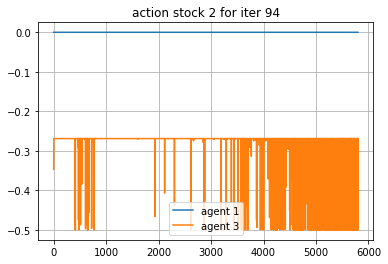

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.         0.         0.50000733 0.4999927 ]]
['MSFT.csv' 'AAPL.csv']


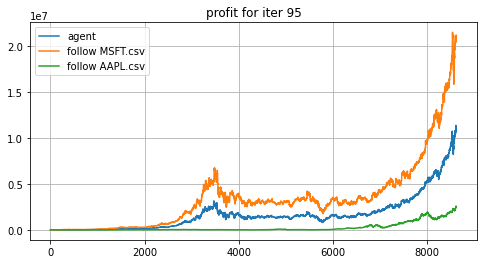

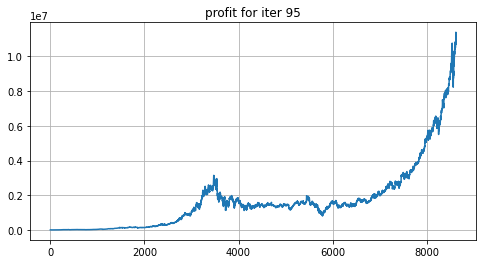

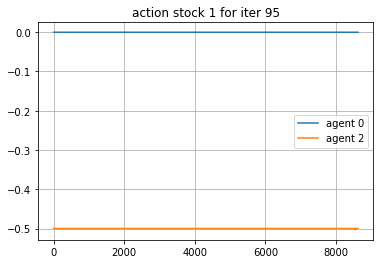

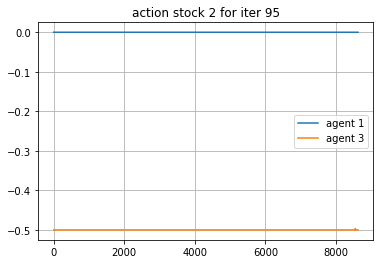

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 5.9604645e-08 5.0000000e-01 5.0000000e-01]]
['RELIN.csv' 'AMZN.csv']


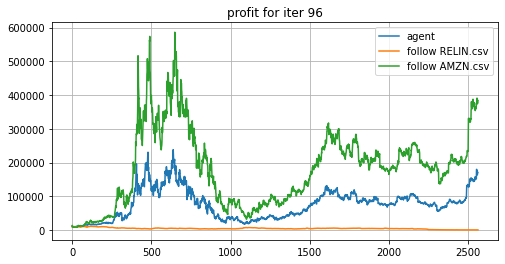

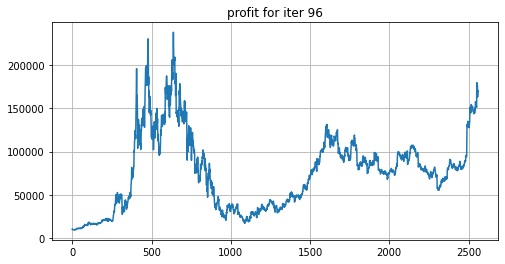

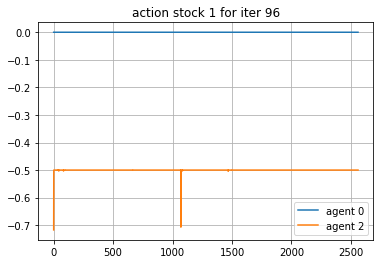

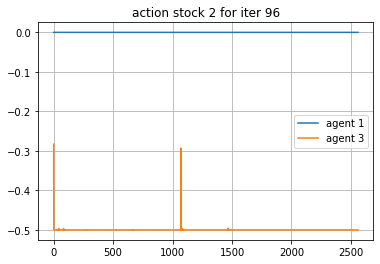

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 5.9604645e-08 2.6938215e-01 7.3061788e-01]]
['GOOG.csv' 'PCG.csv']


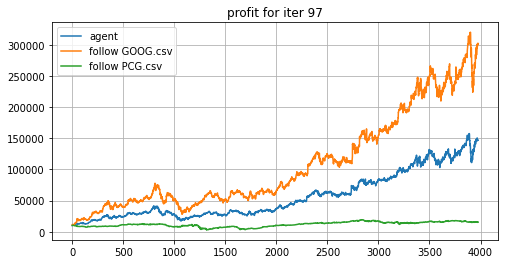

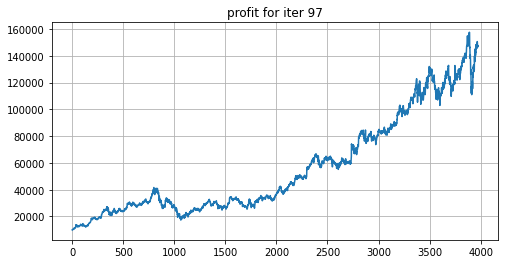

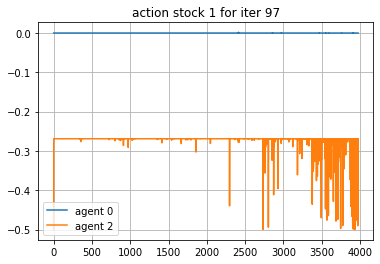

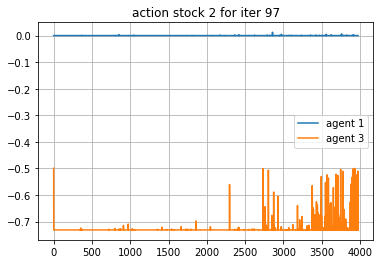

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[1.1920929e-07 1.8179417e-06 2.6894268e-01 7.3105735e-01]]
['RELIN.csv' 'M.csv']


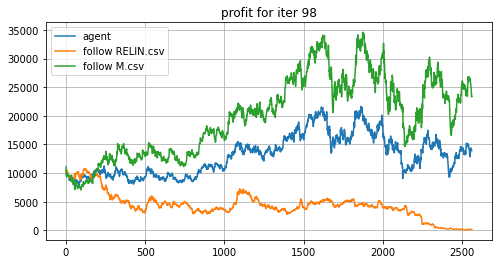

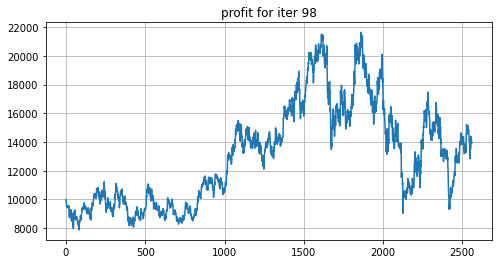

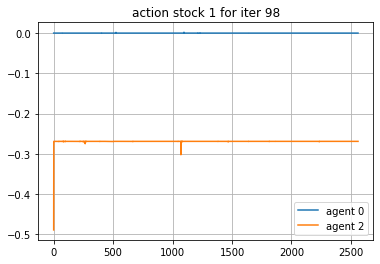

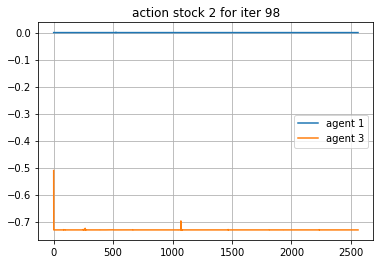

/home/harshit/anaconda3/envs/tf1/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0000000e+00 1.1920929e-07 2.6894149e-01 7.3105848e-01]]
['DXC.csv' 'MSFT.csv']


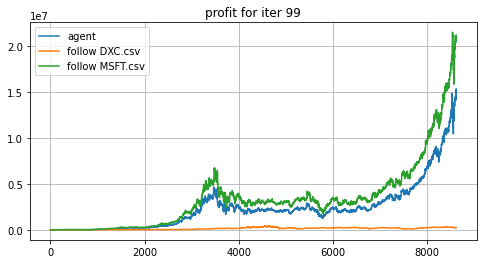

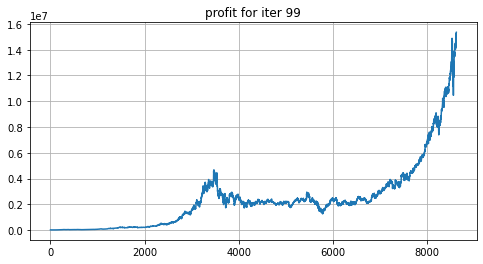

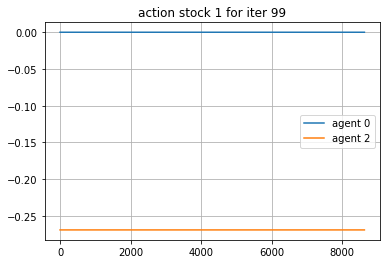

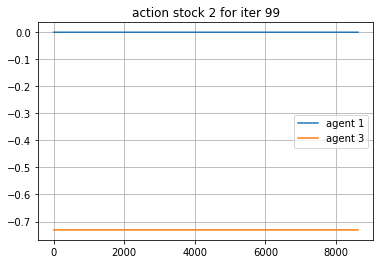

In [20]:
class CustomDDPGPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomDDPGPolicy, self).__init__(*args, **kwargs, reuse = True,
                                           layers=[128, 64],
                                           layer_norm=True,
                                           feature_extraction="lnmlp")

stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
for j in range(100):    
    files = np.random.choice(stocks,2)
#     print(files)
    env = create_stock_env(files,train=False)
    env_test = create_stock_env(files,train=False)
    max_steps = env.max_steps - env.num_prev
    env = DummyVecEnv([lambda: env])
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(0, 2)
    param_noise = AdaptiveParamNoiseSpec(initial_stddev=1, desired_action_stddev=0.1, adoption_coefficient=1.01)
#     model = DDPG(CustomDDPGPolicy, env, verbose=0, param_noise=param_noise, action_noise=action_noise)
    model = DDPG.load("Stock_stable",env=env)
    model.learn(total_timesteps=1000)
    model.save("Stock_stable")

    profitst = np.zeros(max_steps-1)
    profit=10000
    actionst = np.zeros((max_steps-1, n_actions))
    env = DummyVecEnv([lambda: env_test])
    obs = env.reset()
    for i in range(max_steps):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        actionst[i] = action
#         print('a',action)
        profit += rewards
        profitst[i] = profit
        if dones:
            break
    print(action)

    print(files)
    plot_profit(files,profitst,max_steps-1,j)
    plot_action(actionst,j)

In [18]:
max_steps = 5000
files = ['AAPL.csv','IBM.csv']
plot_profit(files,profitst,max_steps,'')
plot_action(actionst,'')

[[0.83680093 0.39965898 0.45288515 0.31861389]
 [0.85732925 0.38376352 0.45588118 0.31606942]
 [0.86588633 0.37097353 0.46353507 0.31620663]
 [0.8579303  0.38051519 0.45438492 0.31289554]
 [0.88108265 0.33617744 0.46626675 0.31951585]
 [0.87235713 0.36192271 0.46232742 0.31451711]
 [0.85937595 0.37155142 0.45654625 0.31462941]
 [0.85632598 0.38176972 0.45310724 0.31298304]
 [0.85436308 0.38919216 0.45780185 0.31767461]
 [0.81834674 0.41712928 0.438032   0.31780729]
 [0.87626106 0.3531673  0.46312878 0.31505352]
 [0.87444222 0.35632914 0.4635596  0.3160094 ]
 [0.86455286 0.36638981 0.45528913 0.3133564 ]
 [0.87460732 0.35723484 0.46383104 0.31362975]
 [0.8409971  0.39771453 0.45636216 0.31792599]
 [0.8609097  0.37904963 0.46127206 0.31507573]
 [0.88179815 0.3451674  0.46372655 0.31341237]
 [0.87891161 0.32819551 0.46951923 0.32771575]
 [0.88133734 0.33170801 0.46713361 0.32362264]
 [0.86708069 0.36655545 0.45570835 0.31115031]
 [0.87599802 0.35031933 0.47050402 0.32156467]
 [0.87541467 